# RNN Sequence Prediction for Music Generation

Goal of this lecture is to train a network that is able to compose new music using a recurrent neural network (RNN) for sequence prediction.

---
### Course of Action

* Please write all executable python code in ```Code```-Cells (```Cell```->```Cell Type```->```Code```) and all Text as [Markdown](http://commonmark.org/help/) in ```Markdown```-Cells
* Describe your thinking and your decisions (where appropriate) in an extra Markdown Cell or via Python comments
* In general: discuss all your results and comment on them (are they good/bad/unexpected, could they be improved, how?, etc.). Furthermore, visualise your data (input and output).
* Write a short general conclusion at the end of the notebook
* Further experiments are encouraged. However, don't forget to comment on your reasoning.
* Use a scientific approach for all experiments (i.e. develop a hypothesis or concrete question, make observations, evaluate results)

### Submission

Upload the complete Notebook to [Ilias](https://learn.mi.hdm-stuttgart.de/) One Notebook per Group is enough. Edit the teammember table below. One Notebook per Group is enough. Edit the teammember table below.

**Important**: Also attach a HTML version of your notebook (```File```->```Download as```->```HTML```) in addition to the ```.ipynb```-File.

| Teammember |                    |
|------------|--------------------|
| 1.         | Nadine Weber    |
| 2.         | Patrick Singer      |
| 3.         | Milos Aleksic         |

<font color="blue">
For better differentiation, all added comments from us will be marked in blue color.</font>

## Prerequisities
1. Make sure you have a general understanding how RNNs are able to take time-series input and predict the future. A general overview of RNNs and different architectures can be found in the Machine Learning lecture [here](https://gitlab.mi.hdm-stuttgart.de/maucher/ML/blob/master/nb/RecurrentNeuralNetworks.ipynb). A practical example how future samples can be predicted can be found [here](https://gitlab.mi.hdm-stuttgart.de/maucher/ML/blob/master/nb/LSTMtemperature.ipynb). 

2. Make sure to have the following python libraries installed (e.g. via ```pip install```)
    * tensorflow
    * keras (or use the [```tensorflow.keras```](https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/keras) module
    * [music21](http://web.mit.edu/music21/)
    * scipy

## Understanding the Input

To be able to compose new music (that ideally does not sound like random notes), the network needs to *listen* to music. Intuitivley the network will try to create music that sounds similar (tone color, rythm, etc.) to the music it listened to during the training.

We use midi-files due to their wide availability to generate the input to our network. A good ressource of free, classical midi-files can be found on the [Classical Piano Midi Page](http://www.piano-midi.de), however you can use any other ressource of midi-files (However, it works best with files with a single *track* (a single instrument).

A midi-file is a simple series of commands (e.g. ```note_on``` or ```note_off```) with a given time offset. To parse the midi-files we use the [music21](http://web.mit.edu/music21/) library. This library offers a wide range of musical analysis functions. We, for now, use it to parse midi files and to normalize the input.

#### Tasks:
* Download a set of midi-files for training (e.g. all compositions of a single artist).
* Load one of the files using music21
* Print the parsed file-structure
* Show an inline player for the file in your browser

#### Hints:
* Use a [```music21.converter```](http://web.mit.edu/music21/doc/moduleReference/moduleConverter.html#module-music21.converter) to read the file
* Use the [```Music21Object.show()```](http://web.mit.edu/music21/doc/moduleReference/moduleBase.html#music21.base.Music21Object.show) method to render the file in different formats.

In [1]:
import music21
import os
import copy
import time
import random
import tensorflow as tf
from datetime import datetime

tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

In [2]:
# This variable was defined to only run all cells that define a function for faster restart times
load_only_functions = False

#### Load example file & print file structure

In [144]:
if not load_only_functions:
    test_file = "./midi_files/mozart/mz_311_1.mid"
    midi_file = music21.converter.parse(test_file)

    for part in midi_file.parts:
        print(part.partName)
        for measure in part.getElementsByClass('Measure')[:2]:  # Measure = Takt
            # print the measure number and contents
            print('Measure', measure.number)
            measure.show('text')

Piano right
Measure 1
{0.0} <music21.instrument.Piano 'Piano right: Piano right'>
{0.0} <music21.instrument.Piano 'Piano'>
{0.0} <music21.clef.TrebleClef>
{0.0} <music21.tempo.MetronomeMark allegrissimo Quarter=141.83>
{0.0} <music21.key.Key of D major>
{0.0} <music21.meter.TimeSignature 4/4>
{0.0} <music21.chord.Chord A4 D5 F#4>
{1.0} <music21.note.Rest quarter>
{2.0} <music21.tempo.MetronomeMark Quarter=147.83>
{2.0} <music21.note.Note G>
{2.25} <music21.note.Note F#>
{2.5} <music21.note.Note E>
{2.75} <music21.note.Note F#>
{3.0} <music21.note.Note A>
{3.25} <music21.note.Note G>
{3.5} <music21.tempo.MetronomeMark Quarter=135.83>
{3.5} <music21.note.Note F#>
{3.75} <music21.note.Note G>
Measure 2
{0.0} <music21.tempo.MetronomeMark Quarter=148.83>
{0.0} <music21.note.Note A>
{1.0} <music21.tempo.MetronomeMark Quarter=146.83>
{1.0} <music21.note.Rest quarter>
{2.0} <music21.tempo.MetronomeMark Quarter=148.83>
{2.0} <music21.note.Note A>
{2.25} <music21.note.Rest 16th>
{2.5} <music21.n

<font color="blue"><b>Comment:</b></font> When printing the content of the midi file, we can see that notes, tempo marks and other objects are grouped together by their measure. In the beginning, the instrument is defined. Further, the notes are grouped in parts.

#### Show track in inline player

In [4]:
if not load_only_functions:
    midi_file = music21.converter.parse(test_file)
    midi_file.show("midi")

As you can see, music21 automatically detects chords when multiple notes are played at the same time. This is helpful as this allows to represent multiple notes as a single symbol. Thus, the model can be trained on one-hot encoded data and still be able to generate polyphonic music.

The next step is to encode the songs into a list of tones. For simple music generation, we ignore the beat and tempo of the music and treat the songs as a series of equidistant notes or chords. 

#### Tasks:
* parse all midi files and put all notes and chords into a single list

#### Hints:
* Midi files may contain multiple *parts* (tracks, instruments, etc.) or are *flat* (notes and chords are not nested in parts). Use [```music21.stream.Stream.recurse()```](https://web.mit.edu/music21/doc/moduleReference/moduleStreamBase.html#music21.stream.base.Stream.recurse) to walk over all files and flatten the structure.
* For [```music21.note.Note```](http://web.mit.edu/music21/doc/moduleReference/moduleNote.html#note) objects, add the ```pitch``` to the tones list. For [```music21.chord.Chord```](http://web.mit.edu/music21/doc/moduleReference/moduleChord.html#chord) objects, join all notes in the chord using a seperator (e.g. ```.```). It is important to narmalize the chord to its [```normalOrder```](http://web.mit.edu/music21/doc/moduleReference/moduleChord.html#music21.chord.Chord.normalOrder) to reduce the number of unique elements drastically without altering the training data too significantly. If the unnormalized chords are used, the traiing set is full of classes that only appear very rarely.

<font color="blue"><h5>FUNCTION: Extract Notes</h5></font>
Takes a loaded midi file and returns a list for notes and for durations. Notes, Rests and Chords are considered. This function was initially only extracting notes and chords. It was later expanded to also extract pauses (rests) and the durations for every element.
* `include_rests` = Include rests in the output lists
* `only_first_part` = If true, only returns notes from the main part (Erste Stimme)
* `normalize_chords` = If true, chords are saved without the octaves of their notes

In [5]:
def extract_notes(midi_file, include_rests=False, only_first_part=False, normalize_chords=True, use_flat=False):
    # Save note and durations separately
    notes = [] # Saves Notes as "C4", Chords as "D4_A2" and Pauses as "P"
    durations = [] # Saves one duration for every element in notes

    # Determine if all parts or only first part included
    if not use_flat:
        iterator_obj = midi_file.getElementsByClass("Part")[0].recurse() if only_first_part else midi_file.recurse()
    else:
        iterator_obj = midi_file.getElementsByClass("Part")[0].flat.elements if only_first_part else midi_file.flat.elements

    # Filter elements for Notes, Chords and Rests
    for element in iterator_obj:
        # TYPE: Rest
        if type(element) == music21.note.Rest and include_rests:
            notes.append("P")
            durations.append(float(element.quarterLength))
        # TYPE: Note
        elif type(element) == music21.note.Note:
            notes.append(element.nameWithOctave)
            durations.append(float(element.quarterLength))
        # TYPE: Chord
        elif type(element) == music21.chord.Chord:
            chord_notes = [note.name if normalize_chords else note.nameWithOctave for note in element.notes]
            notes.append("_".join(chord_notes))
            durations.append(float(element.quarterLength))
    
    return notes, durations

<font color="blue"><h5>FUNCTION: Extract Notes from MIDI Files</h5></font>
Loads all midi files in a given folder and converts them to a notes and durations list using the **extract_notes** function
* `include_rests`, `only_first_part`, `normalize_chords` = See **extract_notes** function
* `flatten_list` = If true, returns only one list. If false, one list per track
* `verbose` = Print information about loaded data
* `limit` = Limits the read files (This was included to test configurations faster, as the loading of many midi files takes a long time)

In [6]:
def extract_notes_from_midi_files(folder_path, include_rests=False, only_first_part=False, normalize_chords=True, flatten_list=True, verbose=True, limit=100):
    # Save notes and durations separately
    files_notes = []
    files_durations = []
    parsed_files = 0

    # Parse all midi files
    for file in os.listdir(folder_path)[:limit if len(os.listdir(folder_path)) > limit else len(os.listdir(folder_path))]:
        if file.endswith(".mid"):
            try:
                midi_file = music21.converter.parse(folder_path + "/" + file)
                notes, durations = extract_notes(midi_file, include_rests=include_rests, only_first_part=only_first_part, normalize_chords=normalize_chords)

                files_notes.append(notes)
                files_durations.append(durations)
                parsed_files += 1
            except:
                print("Skipping corrupted midi file", file)
    
    # Flatten to one list, if flatten_list is True
    if flatten_list:
        files_notes = [item for sublist in files_notes for item in sublist]
        files_durations = [item for sublist in files_durations for item in sublist]
    
    # Print information
    if verbose:
        flatten_placeholder = [item for sublist in files_notes for item in sublist]
        print(f"Loaded notes from {parsed_files} midi files")
        print(f"Total number of notes: {len(files_notes) if flatten_list else len(flatten_placeholder)}")
        print(f"Number of unique notes: {len(set(files_notes)) if flatten_list else len(set(flatten_placeholder))}") 
              
    return files_notes, files_durations

<font color="blue"><h5>FUNCTION: Create MIDI</h5></font>
Creates a music21 Stream object that can be played in the inline player.
* `notes` = List of notes
* `durations` = List of durations, if none given, defaults to a quarter
* `instrument` = Choose the intrument by name (Needs to be a valid music21 instrument)

In [7]:
def create_midi(notes, durations=None, instrument="Piano"):
    if durations is None:
        durations = [.5]*len(notes)

    stream = music21.stream.Stream()
    stream.insert(0, music21.instrument.fromString(instrument))

    for i, element in enumerate(notes):
        # TYPE: Rest
        if element == "P":
            stream.append(music21.note.Rest(quarterLength=durations[i]))
        # TYPE: Chord
        elif "_" in element:
            stream.append(music21.chord.Chord(element.split("_"), quarterLength=durations[i]))
        # TYPE: Note
        else:
            stream.append(music21.note.Note(element, quarterLength=durations[i]))

    return stream

<font color="blue"><h5>Testing the notes extraction</h5></font>
In order to test, if the notes are extracted correctly, we extract a group of tracks, combine them and play them back. We can hear that the notes are still in the supposed order and the durations are applied correctly. As expected, the track sound a little different as properties such as intensity were not included in the extraction.  

In [8]:
import warnings
warnings.filterwarnings("ignore", message="Unable to determine instrument")

if not load_only_functions:
    all_files_notes, all_files_durations = extract_notes_from_midi_files("./midi_files/mozart", flatten_list=True, limit=5)
    all_tracks = create_midi(all_files_notes[:1000], all_files_durations[:1000])  # Only first 1000 notes
    all_tracks.show("midi")
    all_tracks.write("midi", "./generated_music/test_file_for_note_extraction.mid")

Loaded notes from 5 midi files
Total number of notes: 13379
Number of unique notes: 328


<font color="blue"><h5>Plot for note distribution</h5></font>
The function creates multiple plots for a list of notes. It shows the frequency of each note (up to a specified limit) and the distribution between chords and single notes. We wrote this function so we can see at a glance what the dataset consists of and what can be removed to decrease complexity.
* `notes_list` = a list of notes, chords and pauses
* `max_bars` = number of bars that are displayed for the most frequent notes/chords
* `chord_marker` = Determines with which symbols chords are joined together

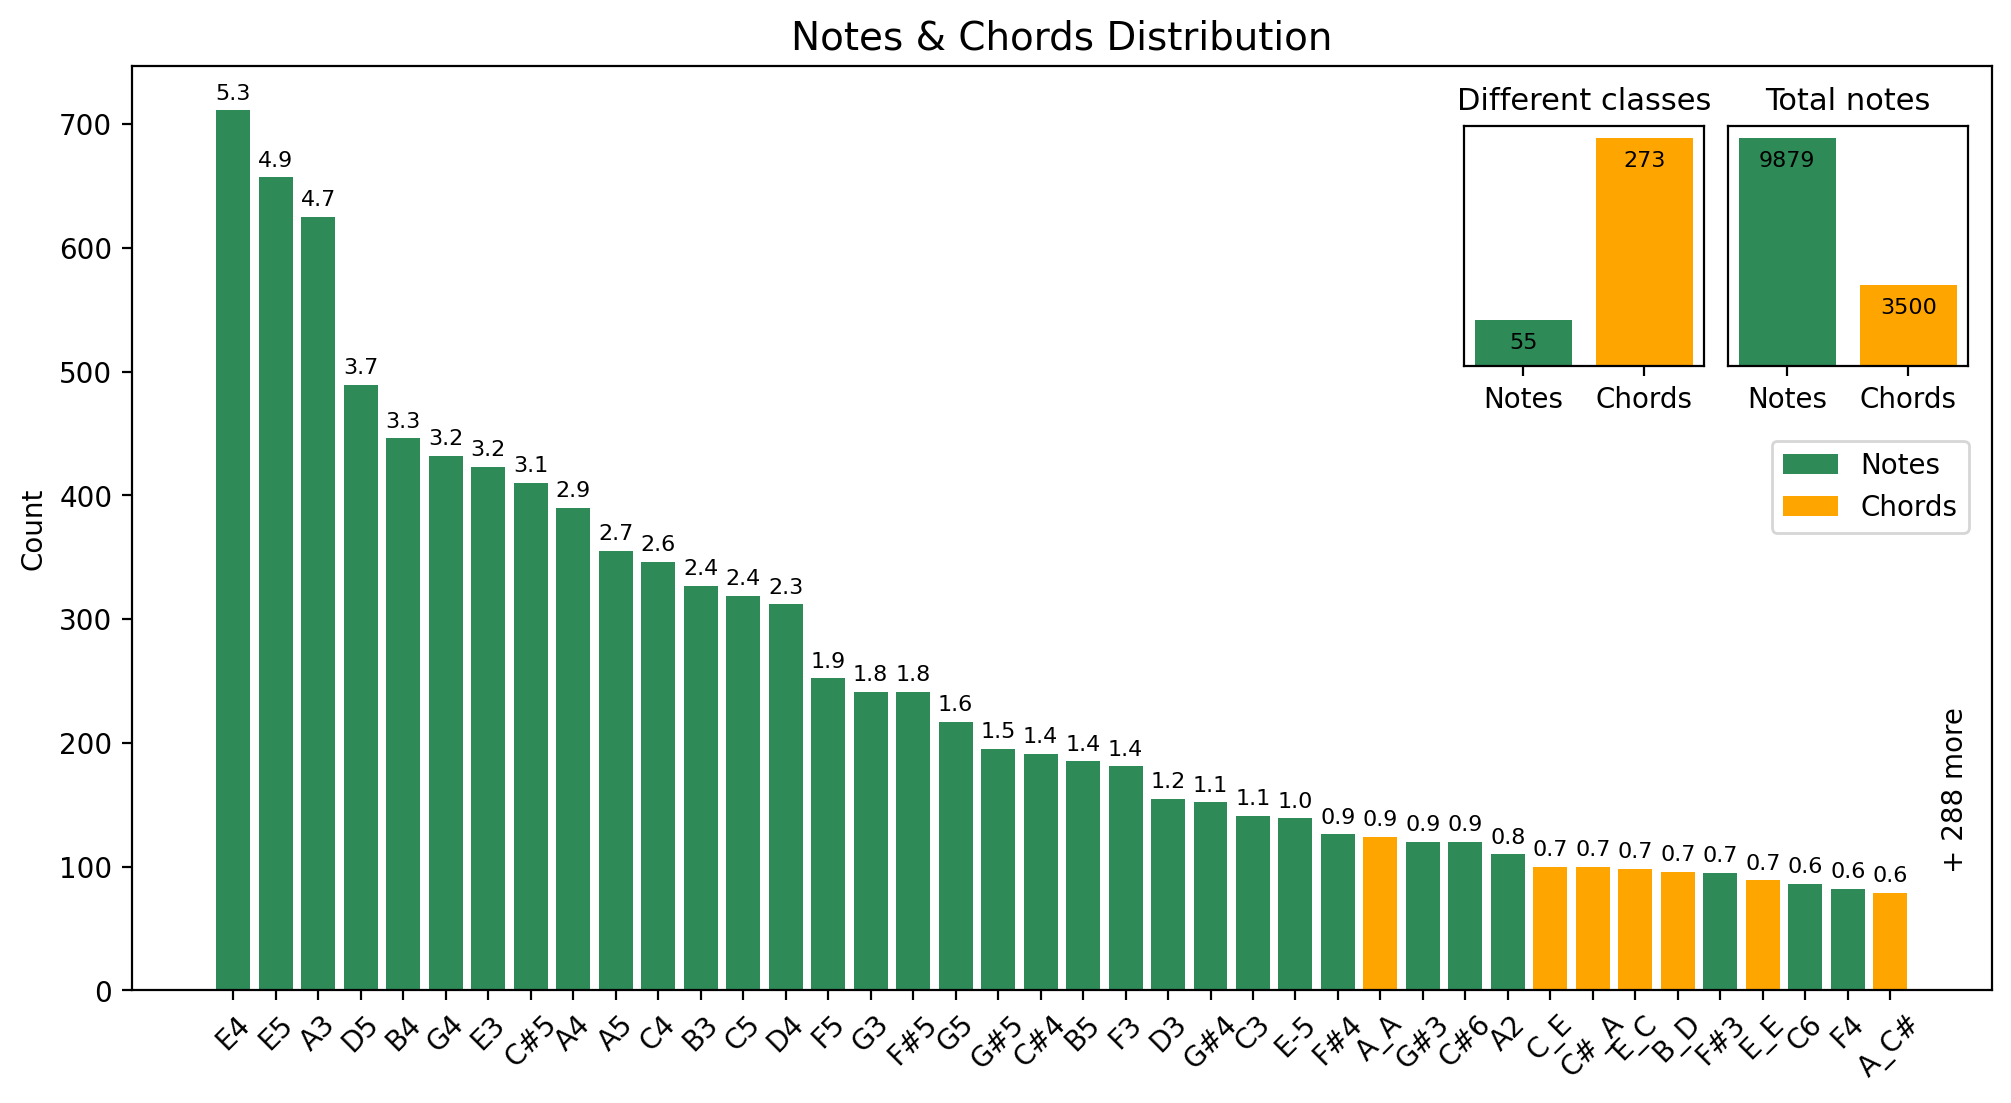

In [9]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from collections import Counter
%matplotlib inline

def plot_notes(notes_list, max_bars=40, chord_marker="_"):
    sorted_notes = Counter(notes_list).most_common()
    notes, counts = [val[0] for val in sorted_notes], [val[1] for val in sorted_notes]
    
    # General plot elements
    plt.figure(figsize=(12, 6))
    plt.bar(notes[:max_bars], counts[:max_bars], color=["orange" if chord_marker in val else "seagreen" for val in notes])
    plt.title("Notes & Chords Distribution", fontsize=14)
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    
    # Print info that plot was cut
    if max_bars < len(notes):
        plt.text(40.2, 100, f"+ {len(notes) - max_bars} more", rotation=90)
    
    # Print percentage
    for x, y in zip(notes[:max_bars], counts[:max_bars]):
        plt.text(x, y + max(counts[:max_bars])/80, f"{(y / sum(counts) * 100):.1f}", ha="center", fontsize=8)
    
    # Legend
    legend_elements = [Patch(facecolor='seagreen', label='Notes'), Patch(facecolor='orange', label='Chords')]
    plt.legend(handles=legend_elements, bbox_to_anchor=(.995, .61))
    
    # Side plots 
    total_notes = [counts[i] for i in range(len(notes)) if chord_marker not in notes[i]]
    total_chords = [counts[i] for i in range(len(notes)) if chord_marker in notes[i]]
    
    num_plt = plt.axes([0.79, 0.63, 0.1, 0.2])
    num_plt.bar(["Notes", "Chords"], [sum(total_notes), sum(total_chords)], color=["seagreen", "orange"])
    num_plt.set_yticks([])
    num_plt.set_title("Total notes", fontsize=11)
    for x, y in zip(["Notes", "Chords"], [sum(total_notes), sum(total_chords)]):
        num_plt.text(x, y - max([sum(total_notes), sum(total_chords)])/8, str(y), ha="center", fontsize=8)
    
    per_plt = plt.axes([0.68, 0.63, 0.1, 0.2])
    per_plt.bar(["Notes", "Chords"], [len(total_notes), len(total_chords)], color=["seagreen", "orange"])
    per_plt.set_yticks([])
    per_plt.set_title("Different classes", fontsize=11)
    for x, y in zip(["Notes", "Chords"], [len(total_notes), len(total_chords)]):
        per_plt.text(x, y - max([len(total_notes), len(total_chords)])/8, str(y), ha="center", fontsize=8)
    
    plt.show()

if not load_only_functions:  
    plot_notes(all_files_notes)

<font color="blue"><b>Comment:</b></font> When plotting 5 tracks by mozart, we can see that the most frequent notes are all single notes and not chords with E4, E5 and A3 occuring the most. In the distribution graphs we added to the plot on the top right, we can see that despite notes making up most of the elements, the chords are comprised of much more classes. <br>
**Note:** For training later we use the complete mozart dataset.

<font color="blue"><h5>FUNCTION: Limit number of notes</h5></font>
The function takes in a list of notes and optional durations and only keeps the most frequent notes. The cut off point can be changed. 
* `notes` = a list of notes, chords and pauses
* `durations` = an optional list containing the duration for each element in the notes list
* `limit` = The number of classes/different notes the input data is cut to

In [10]:
def limit_different_notes(notes, durations=None, limit=100):
    included_notes = [val[0] for val in Counter(notes).most_common()[:limit]]
    clipped_notes, clipped_durations = [], []

    for i in range(len(notes)):
        if notes[i] in included_notes:
            clipped_notes.append(notes[i])
            if durations is not None:
                clipped_durations.append(durations[i])

    print(f"Removed {len(notes) - len(clipped_notes)} notes to get to {len(set(clipped_notes))} classes ({len(clipped_notes)} total notes remaining)")
    return clipped_notes, clipped_durations

Removed 1067 notes to get to 100 classes (12312 total notes remaining)


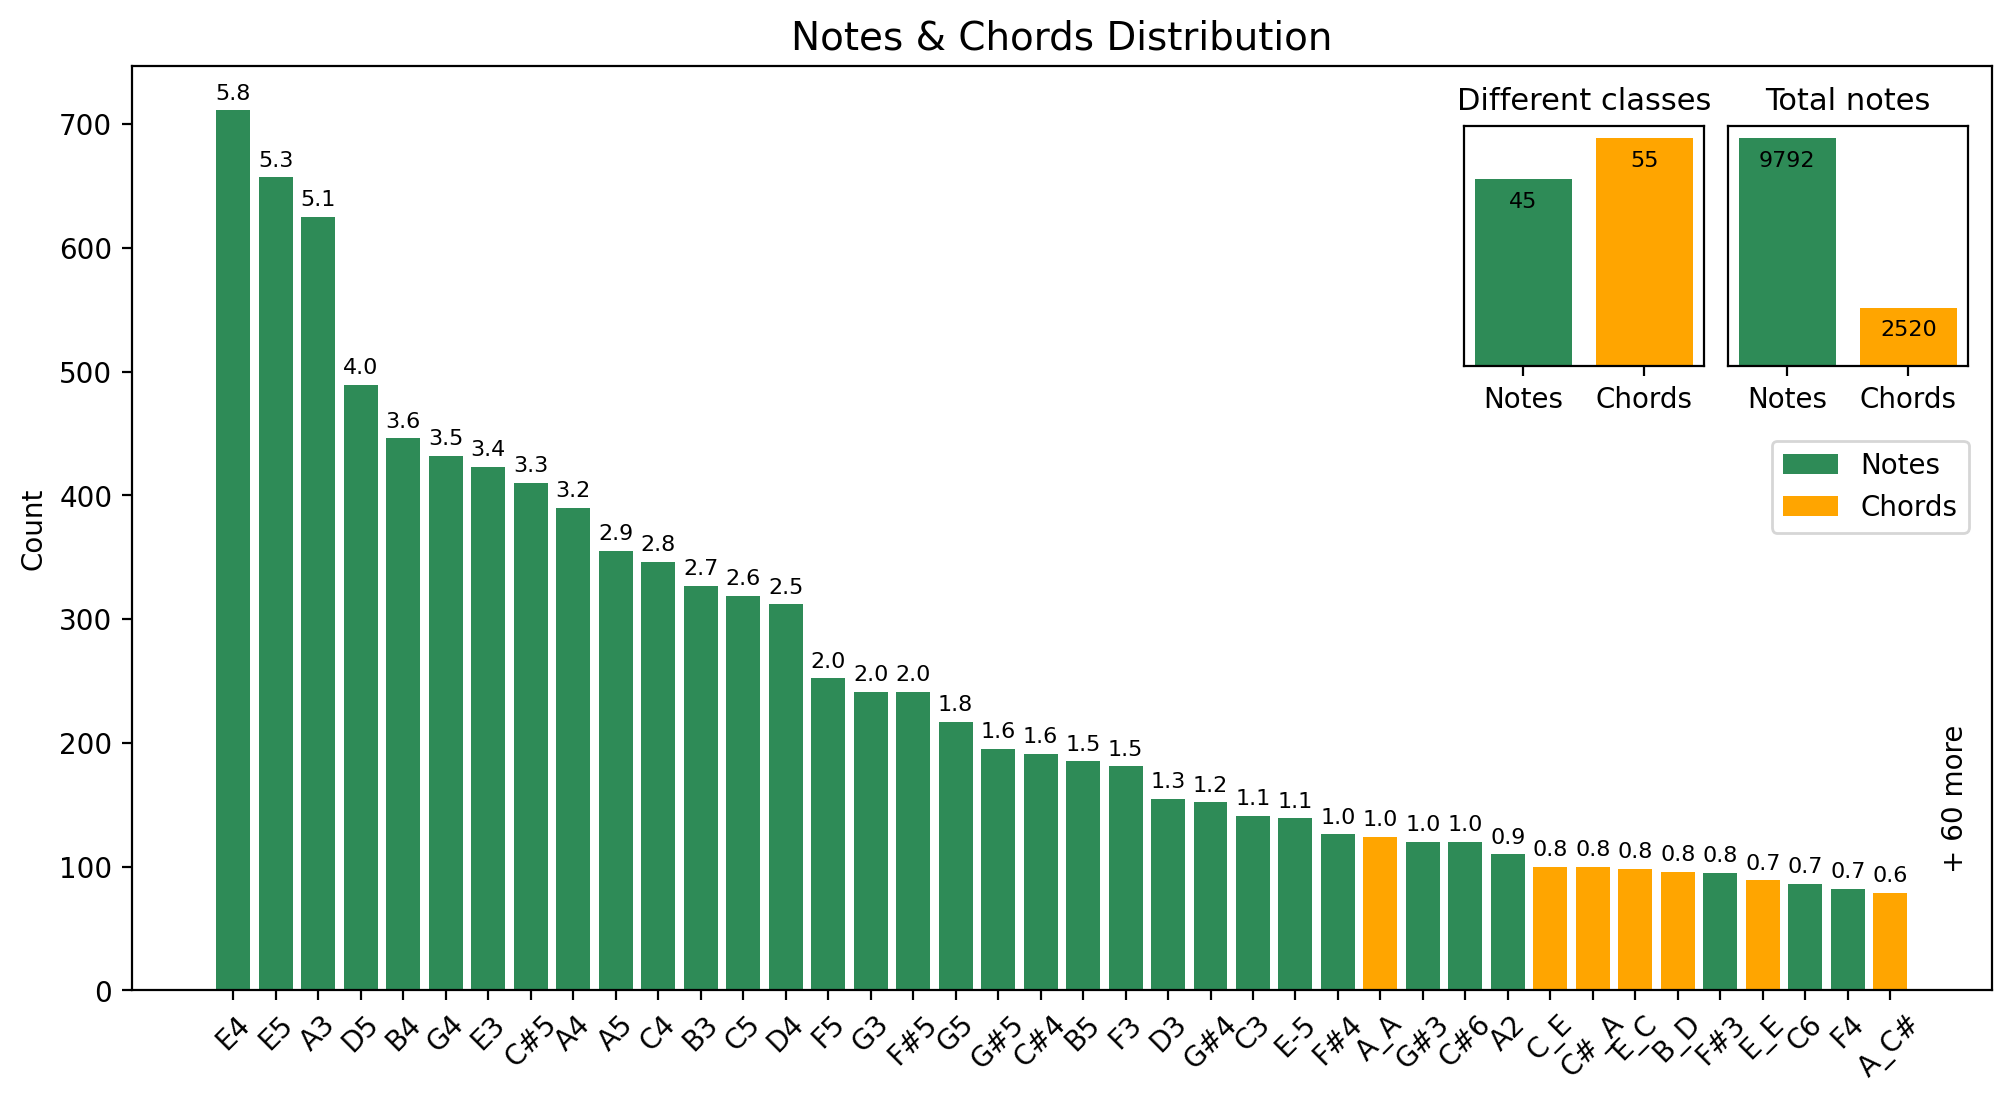

In [11]:
if not load_only_functions:
    clipped_notes, clipped_durations = limit_different_notes(all_files_notes, all_files_durations)
    plot_notes(clipped_notes)

<font color="blue"><b>Comment:</b></font> After limiting the classes, we can see that most chord classes were cut and the chords and notes class distribution is now roughly equal.

## Create training data

We train the network to predict the next note or chord after it has seen a sequence of previous tones. Therefore, each input element is a sequence of tones and the label is the next note or chord followed by this sequence.

Until now, each tone is represented by a string. For the output, this representation needs to be converted to one-hot encoded vectors to be able to train the model using categorical cross-entropy. The input needs to be mapped to floats in $[0,1|$ that are used as input to the network.

<img alt="preprocess" src="data:image/svg+xml,%3C%3Fxml%20version%3D%221.0%22%20encoding%3D%22UTF-8%22%20standalone%3D%22no%22%3F%3E%0D%0A%3C%21DOCTYPE%20svg%20PUBLIC%20%22-%2F%2FW3C%2F%2FDTD%20SVG%201.1%2F%2FEN%22%20%22http%3A%2F%2Fwww.w3.org%2FGraphics%2FSVG%2F1.1%2FDTD%2Fsvg11.dtd%22%3E%0D%0A%3Csvg%20width%3D%22100%25%22%20height%3D%22100%25%22%20viewBox%3D%220%200%202953%20591%22%20version%3D%221.1%22%20xmlns%3D%22http%3A%2F%2Fwww.w3.org%2F2000%2Fsvg%22%20xmlns%3Axlink%3D%22http%3A%2F%2Fwww.w3.org%2F1999%2Fxlink%22%20xml%3Aspace%3D%22preserve%22%20xmlns%3Aserif%3D%22http%3A%2F%2Fwww.serif.com%2F%22%20style%3D%22fill-rule%3Aevenodd%3Bclip-rule%3Aevenodd%3Bstroke-linecap%3Around%3Bstroke-linejoin%3Around%3Bstroke-miterlimit%3A1.5%3B%22%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C985.827%2C-44%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28202%2C203%2C201%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C965.827%2C-22%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EF4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1068.83%2C-44%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28202%2C203%2C201%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1045.83%2C-22%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3ED4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1150.83%2C-44%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28202%2C203%2C201%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1130.83%2C-22%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EF4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1232.83%2C-44%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28202%2C203%2C201%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1209.83%2C-22%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EC4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1314.83%2C-44%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28202%2C203%2C201%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1292.83%2C-22%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EE4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1396.83%2C-44%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28202%2C203%2C201%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1374.83%2C-22%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EC6%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1478.83%2C-44%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28202%2C203%2C201%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1456.83%2C-22%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EB4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1560.83%2C-44%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28202%2C203%2C201%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1531.83%2C-22%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EB-4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1232.83%2C96%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28151%2C208%2C119%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1209.83%2C118%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EC4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1314.83%2C96%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28151%2C208%2C119%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1292.83%2C118%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EE4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1396.83%2C96%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28151%2C208%2C119%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1374.83%2C118%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EC6%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1478.83%2C96%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28151%2C208%2C119%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1456.83%2C118%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EB4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1560.83%2C96%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28166%2C219%2C223%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1531.83%2C118%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EB-4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1642.83%2C-44%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28202%2C203%2C201%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1609.83%2C-22%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EF%234%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1314.83%2C236%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28151%2C208%2C119%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1292.83%2C258%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EE4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1396.83%2C236%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28151%2C208%2C119%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1374.83%2C258%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EC6%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1478.83%2C236%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28151%2C208%2C119%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1456.83%2C258%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EB4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1560.83%2C236%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28151%2C208%2C119%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1531.83%2C258%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EB-4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1642.83%2C236%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28166%2C219%2C223%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1609.83%2C258%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EF%234%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1724.83%2C-44%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28202%2C203%2C201%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1701.83%2C-22%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EC%23%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1396.83%2C376%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28151%2C208%2C119%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1374.83%2C398%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EC6%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1478.83%2C376%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28151%2C208%2C119%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1456.83%2C398%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EB4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1560.83%2C376%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28151%2C208%2C119%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1531.83%2C398%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EB-4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1642.83%2C376%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28151%2C208%2C119%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1609.83%2C398%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EF%234%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1724.83%2C376%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28166%2C219%2C223%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1701.83%2C398%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EC%23%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1806.83%2C-44%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28202%2C203%2C201%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1784.83%2C-22%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EB4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1888.83%2C-44%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28202%2C203%2C201%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1866.83%2C-22%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EB5%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C985.827%2C-44%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M331.35%2C186.521L331.36%2C128.531%22%20style%3D%22fill%3Anone%3Bstroke%3Ablack%3Bstroke-width%3A1px%3Bstroke-dasharray%3A3%2C3%2C0%2C0%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C985.827%2C-44%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M659.35%2C186.521L659.35%2C128.531%22%20style%3D%22fill%3Anone%3Bstroke%3Ablack%3Bstroke-width%3A1px%3Bstroke-dasharray%3A3%2C3%2C0%2C0%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C985.827%2C-44%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M413.35%2C326.521L413.35%2C128.531%22%20style%3D%22fill%3Anone%3Bstroke%3Ablack%3Bstroke-width%3A1px%3Bstroke-dasharray%3A3%2C3%2C0%2C0%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C985.827%2C-44%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M741.35%2C326.521L741.35%2C128.531%22%20style%3D%22fill%3Anone%3Bstroke%3Ablack%3Bstroke-width%3A1px%3Bstroke-dasharray%3A3%2C3%2C0%2C0%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C985.827%2C-44%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M495.36%2C466.414L495.35%2C128.531%22%20style%3D%22fill%3Anone%3Bstroke%3Ablack%3Bstroke-width%3A1px%3Bstroke-dasharray%3A3%2C3%2C0%2C0%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C985.827%2C-44%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M823.36%2C466.414L823.36%2C128.531%22%20style%3D%22fill%3Anone%3Bstroke%3Ablack%3Bstroke-width%3A1px%3Bstroke-dasharray%3A3%2C3%2C0%2C0%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C985.827%2C-44%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M905.36%2C466.521L905.36%2C128.531%22%20style%3D%22fill%3Anone%3Bstroke%3Ablack%3Bstroke-width%3A1px%3Bstroke-dasharray%3A3%2C3%2C0%2C0%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%280.50007%2C0%2C0%2C1%2C1601.35%2C-303.498%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M275.736%2C494.2L275.736%2C479.848L374.611%2C479.848L374.611%2C466.521L415.61%2C487.024L374.611%2C507.526L374.611%2C494.2L275.736%2C494.2Z%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%280.50007%2C0%2C0%2C1%2C1683.35%2C-163.498%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M275.736%2C494.2L275.736%2C479.848L374.611%2C479.848L374.611%2C466.521L415.61%2C487.024L374.611%2C507.526L374.611%2C494.2L275.736%2C494.2Z%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%280.50007%2C0%2C0%2C1%2C1765.35%2C-23.4975%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M275.736%2C494.2L275.736%2C479.848L374.611%2C479.848L374.611%2C466.521L415.61%2C487.024L374.611%2C507.526L374.611%2C494.2L275.736%2C494.2Z%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1103.37%2C6.19147%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22517.599px%22%20y%3D%22569.231px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A62.5px%3B%22%3EX%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C437.584%2C-364.362%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22517.599px%22%20y%3D%22569.231px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A62.5px%3B%22%3Eseq%3C%2Ftext%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22602.974px%22%20y%3D%22590.044px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A36.438px%3B%22%3E4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C383.584%2C-514.362%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22517.599px%22%20y%3D%22569.231px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A62.5px%3B%22%3Enotes%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C437.584%2C-234.362%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22517.599px%22%20y%3D%22569.231px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A62.5px%3B%22%3Eseq%3C%2Ftext%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22602.974px%22%20y%3D%22590.044px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A36.438px%3B%22%3E5%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C437.584%2C-94.3615%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22517.599px%22%20y%3D%22569.231px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A62.5px%3B%22%3Eseq%3C%2Ftext%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22602.974px%22%20y%3D%22590.044px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A36.438px%3B%22%3E6%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%28-0.00034298%2C1%2C-1%2C-0.00034298%2C1573.35%2C-16.572%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22517.599px%22%20y%3D%22569.231px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A62.5px%3B%22%3E...%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%28-0.00034298%2C1%2C-1%2C-0.00034298%2C1570.03%2C-421.634%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22517.599px%22%20y%3D%22569.231px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A62.5px%3B%22%3E...%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1314.37%2C6.19147%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22517.599px%22%20y%3D%22569.231px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A62.5px%3B%22%3Ey%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%280.00023754%2C0.71323%2C-4.12755%2C0.00137467%2C4031.46%2C247.776%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22353.101px%22%20y%3D%22598.079px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A79.542px%3B%22%3E%7D%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%280.00023754%2C0.71323%2C-1.03072%2C0.000343278%2C2446.05%2C248.332%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22353.101px%22%20y%3D%22598.079px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A79.542px%3B%22%3E%7D%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%3C%2Fsvg%3E%0D%0A" />

#### Tasks: 
* Create the training elements by following the *shifting* procedure depicted above
* normalize the input sequences to $[0,1|$ and one-hot encode the labels

#### Hints:
* Use a sequence length of ~50-100 notes
* create a mapping from the string-representation of a tone to an int and vice versa
* use [```keras.utils.to_categorical```](https://keras.io/api/utils/python_utils/#tocategorical-function) to convert an integer to a one-hot vector

<font color="blue"><h5>FUNCTION: Creation of the Note to Integer mapping</h5></font>
This function takes in a list of notes and assigns each different note an integer value for later use in training data normalization as well as the one hot encoding of the labels.
* `notes_list` = a list of notes, chords and pauses
* `int_to_note` = If true, creates the mapping reversed. Instead of note names being the key, The integer is the key and note name the value. 

In [12]:
def create_note_to_int_mapping(notes_list, int_to_note=False):
    notes_map = {}
    for i, note in enumerate(set(notes_list)):
        if int_to_note:
            notes_map[i] = note
        else:
            notes_map[note] = i
        
    return notes_map

In [13]:
if not load_only_functions:
    note_mapping = create_note_to_int_mapping(clipped_notes)
    print(note_mapping)

{'E_C#': 0, 'F_G': 1, 'C#3': 2, 'G#_A': 3, 'G2': 4, 'F#4': 5, 'D_C#': 6, 'G_F': 7, 'C#6': 8, 'B_G': 9, 'D_B': 10, 'A4': 11, 'F#_F#': 12, 'G#4': 13, 'B_B': 14, 'C3': 15, 'E-_E': 16, 'B3': 17, 'C6': 18, 'B2': 19, 'G#3': 20, 'G_B': 21, 'G#_E': 22, 'C_C': 23, 'E-5': 24, 'E-4': 25, 'G#_G#': 26, 'B_A': 27, 'C#_D': 28, 'D_F#': 29, 'E_C': 30, 'C#5': 31, 'F_D': 32, 'D6': 33, 'F#5': 34, 'B5': 35, 'F2': 36, 'F#_E': 37, 'G3': 38, 'A_A': 39, 'B4': 40, 'A2': 41, 'G_E': 42, 'C4': 43, 'G#5': 44, 'E4': 45, 'F3': 46, 'E_E': 47, 'C#4': 48, 'D3': 49, 'A_F#': 50, 'D_A': 51, 'G4': 52, 'C#_B': 53, 'B_D': 54, 'E_G': 55, 'D_F': 56, 'C#_C#': 57, 'C#_E': 58, 'E_G#': 59, 'D_D': 60, 'E_F#': 61, 'B_G#': 62, 'A5': 63, 'E2': 64, 'F_F': 65, 'A3': 66, 'E_D': 67, 'F#_A': 68, 'E_B': 69, 'B-4': 70, 'A_C#_E': 71, 'G_G': 72, 'G_A': 73, 'E_A': 74, 'C#_A': 75, 'A_C#': 76, 'F_A': 77, 'B-3': 78, 'A_C': 79, 'E-6': 80, 'E5': 81, 'F5': 82, 'G#_B': 83, 'C5': 84, 'D4': 85, 'F_E': 86, 'A_E': 87, 'D_E': 88, 'C_E': 89, 'A_B': 90, 'F#3'

<font color="blue"><b>Comment:</b></font> The output of the function is a dictionary with note names as the key and their corresponding number as the value.

<font color="blue"><h5>FUNCTION: Creation of the training data</h5></font>
In this function, sequences of notes are created from the data. The training sequences get normalized and the label, which is the note right after each sequence, is getting one-hot-encoded. The function returns the training data as a dictionary separated into input and label, and returns the created mapping of notes to integers. The return of the mappings is needed for later conversion back to readable notes.
* `notes_list` = a list of notes, chords and pauses
* `seq_length` = The length of one training sequence

In [14]:
def create_training_data(notes_list, seq_length=50):
    note_to_int_mapping = create_note_to_int_mapping(notes_list)
    train_data = {"input": [], "label": []}
    
    # Iterate through all sequences of the notes list
    for i in range(len(notes_list))[:-(seq_length+1)]:
        # Normalize the input data
        seq = notes_list[i:i+seq_length]
        int_seq = [note_to_int_mapping[val] for val in seq]
        norm_seq = [val/len(note_to_int_mapping) for val in int_seq]
        train_data["input"].append(norm_seq)
        
        # One hot encode the label
        label_one_hot_enc = tf.keras.utils.to_categorical(note_to_int_mapping[notes_list[i+seq_length]], num_classes=len(note_to_int_mapping))
        train_data["label"].append(label_one_hot_enc)
        
    return train_data, note_to_int_mapping

In [15]:
if not load_only_functions:
    data, note_to_int_mapping = create_training_data(clipped_notes)
    print(f"Created training dataset with {len(data['input'])} entries")

Created training dataset with 12261 entries


#### Split & Reshape Train/Test Data

<font color="blue"><b>Comment:</b></font> We wrapped the `train_test_split` function of sklearn into a separate function to also include reshaping of the data to the required input shape of keras LSTM layers.

In [16]:
from sklearn.model_selection import train_test_split
import numpy as np

def train_test_split_and_reshape(training_data_dict, test_size=0.2, verbose=True):
    X_train, X_test, y_train, y_test = train_test_split(np.array(training_data_dict["input"]), np.array(training_data_dict["label"]), test_size=test_size)
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    if verbose:
        print(f"X_train: {X_train.shape} | y_train: {y_train.shape} | X_test: {X_test.shape} | y_test: {y_test.shape}")

    return X_train, X_test, y_train, y_test

# Create train/test data (This is only an example. We create the training data for the actual training in the complete_lstm_training function)
if not load_only_functions:
    X_train, X_test, y_train, y_test = train_test_split_and_reshape(data)

X_train: (9808, 50, 1) | y_train: (9808, 100) | X_test: (2453, 50, 1) | y_test: (2453, 100)


## Create and train the Network

With the prepared training data, it is now possible to train the network. There are many variants of RNNs (e.g. unidirectional vs. bidirectional and LSTM vs. GRU). You can encouraged to try your own network architecture, however here is an example architecture as a starting point:

* 3 consecutive unidirectional recurrent layer with ```512``` [LSTM](https://keras.io/api/layers/recurrent_layers/lstm/) units, returning all sequence states (not only the last state) to feed into the next recurrent layer (except for the last layer) and [Dropout](https://keras.io/api/layers/regularization_layers/dropout/) with a rate of ```0.3``` between each layer
* a [Dense](https://keras.io/api/layers/core_layers/dense/) layer with ```256``` neurons, ReLU activation and a dropout rate of ```0.3```
* another Dense layer for the output with softmax activation
* RMSProp optimizer using categorical-crossentropy as lossfunction

<font color="blue"><b>Comment:</b></font> We decided to create a function for creating the model to be able to quickly change out the architecture parameters such as number of LSTM layers or units per layer.

In [17]:
def create_lstm_rnn(input_length, output_size, num_lstm_layers=3, lstm_units=512):
    model = tf.keras.Sequential()
    
    # Add LSTM layers (LSTMs need input shape (batch_size, timesteps, features))
    for i in range(num_lstm_layers):
        model.add(tf.keras.layers.LSTM(input_shape=(input_length,1,), units=lstm_units, return_sequences=True if i < num_lstm_layers-1 else False))
        model.add(tf.keras.layers.Dropout(.3))
        
    # Add dense layers
    model.add(tf.keras.layers.Dense(units=256, activation="ReLU"))
    model.add(tf.keras.layers.Dropout(.3))
    model.add(tf.keras.layers.Dense(units=output_size, activation="softmax"))

    return model

<font color="blue"><h5>CLASS: Training Callback</h5></font>
A Callback class used during training that inherits from the keras Callback class. Its purpose is to display a plot with relevant metrics (Loss, Accuracy) and concrete current metric values. The user can specify how often the plot is drawn with the `plot_every_x_epochs` parameter.

In [18]:
class PerfPlotCallback(tf.keras.callbacks.Callback):
    def __init__(self, plot_every_x_epochs=10):
        super().__init__()
        self.train_loss = []
        self.test_loss = []
        self.train_accuracy = []
        self.test_accuracy = []
        self.plot_every_x_epochs = plot_every_x_epochs
        
    @tf.function
    def on_epoch_end(self, epoch, logs=None):
        self.train_loss.append(logs["loss"])
        self.test_loss.append(logs["val_loss"])
        self.train_accuracy.append(logs["accuracy"])
        self.test_accuracy.append(logs["val_accuracy"])
        
        if epoch % self.plot_every_x_epochs == 0 and epoch != 0:
            fig = plt.figure(figsize=(8, 2), dpi=100)
            fig.suptitle(f"Model Performance after Epoch {epoch}", y=1.1)
            plt.figtext(.92, .5, f"Training Loss: {round(logs['loss'], 2)}\nValidation Loss: {round(logs['val_loss'], 2)}\n\nTraining Accuracy: {round(logs['accuracy'], 2)}\nValidation Accuracy: {round(logs['val_accuracy'], 2)}")
            
            plt.subplot(1, 2, 1)
            plt.title("Model Loss", fontsize=11)
            plt.plot(self.train_loss, color="seagreen", label="Training")
            plt.plot(self.test_loss, color="orange", label="Validation")
            plt.legend()
            plt.xlabel("Epoch")
            
            plt.subplot(1, 2, 2)
            plt.title("Model Accuracy", fontsize=11)
            plt.plot(self.train_accuracy, color="seagreen", label="Training")
            plt.plot(self.test_accuracy, color="orange", label="Validation")
            plt.xlabel("Epoch")
            
            plt.show()

<font color="blue"><h5>FUNCTION: Main Training</h5></font>
We created a main training function that includes all previously defined functions in order to run a complete model training including acquiring data, transforming the data, creating training and test partitions, creating and compiling a new model, and training the model. This was done so we can quickly change and test new training data or model hyperparameter. For each training, the best model weights according to validation accuracy are saved.<br>
The function needs the following parameters:
* `midi_files` = The folder path to the midi files intended for training
* `max_classes` = The maximum amount of different notes/chords. If more classes are in the data, the least used get cut
* `input_length` = The length of one training sequence
* `only_first_part` = Refers to the midi file parsing. If true, only the first part (Erste Stimme) is used<br>

Optionally the parameters `num_lstm_layers`, `lstm_units`, `learning_rate`, `batch_size` and `epochs` can be configured for better model tuning. <br>

`plot_every_x_epochs` and `plot_note_dist` can be configured to adjust the amount of plots displayed when training. <br>

Additionaly, the parameter `preloaded_notes_and_durations` was introduced to reduce training time when not switching between different training data. This will overwrite the `midi_files` parameter and will use the already extracted notes given as input.


In [19]:
def complete_lstm_training(midi_files, max_classes, input_length, num_lstm_layers=3, lstm_units=512, 
                           learning_rate=0.01, batch_size=32, epochs=10, plot_every_x_epochs=10,
                           only_first_part=False, preloaded_notes_and_durations=None, plot_note_dist=True):
    
    # Get & transform data
    print(">> Creating training data")
    if preloaded_notes_and_durations is None:
        all_files_notes, all_files_durations = extract_notes_from_midi_files(midi_files, flatten_list=True, only_first_part=only_first_part, limit=900)
    else:
        all_files_notes, all_files_durations = preloaded_notes_and_durations
        print("Loaded notes and durations from given list")
    
    # Preprocessing of the data
    clipped_notes, clipped_durations = limit_different_notes(all_files_notes, all_files_durations, limit=max_classes)
    data, note_to_int_mapping = create_training_data(clipped_notes, seq_length=input_length)
    X_train, X_test, y_train, y_test = train_test_split_and_reshape(data, verbose=True)
    if plot_note_dist:
        plot_notes(clipped_notes)
    
    # Build model
    print("\n>> Building model")    
    model = create_lstm_rnn(input_length, output_size=len(data["label"][0]), 
                            num_lstm_layers=num_lstm_layers, lstm_units=lstm_units)
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=['accuracy'])
    
    # Training
    print("\n>> Beginning training")
    train_start_time = time.time()
    checkpoint_path = "./checkpoint_data/" + datetime.now().strftime('%d_%m_%Y_%H_%M')
    model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0, validation_data=(X_test, y_test), 
              callbacks=[PerfPlotCallback(plot_every_x_epochs), tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, monitor='val_accuracy', mode='max', save_best_only=True, save_freq="epoch")])
    
    # Finish
    print("\n>> Finished training")
    print(f"Total training time: {round((time.time() - train_start_time)/60)} minutes")
    print("Final training Loss:", model.history.history["loss"][-1])
    print("Final validation Loss:", model.history.history["val_loss"][-1])
    print("Final training Accuracy:", model.history.history["accuracy"][-1])
    print("Final validation Accuracy:", model.history.history["val_accuracy"][-1])

    # Model and relevant training information get returned as a dict
    return {"model": model, "mappings": note_to_int_mapping, "train_data": X_train}
    

As the training of a complex RNN can take a very long time, you should make sure to add a [ModelCheckpoint](https://keras.io/api/callbacks/model_checkpoint/) callback to your model to regularly save the parameters during training.

#### Tasks:
* train your model for 50-100 epochs

#### Hints:
* train your model on a reduced training set and for a single epoch first to make sure you have no programming errors
* the training can take a very long time, use the [Deeplearn Machines @ HDM](https://deeplearn.pages.mi.hdm-stuttgart.de/docs/) to speed up training (significantly!)

<font color="blue"><b>Comment:</b></font> The following training was the best result achieved after testing multiple different hyperparameter combinations for the in the task defined LSTM structure. Below the training we will go into more detail what other combinations were tried.<br>
The midi files used for this training and all subsequent trainings with mozart tracks were downloaded from http://www.piano-midi.de/mozart.htm

>> Creating training data
Loaded notes from 21 midi files
Total number of notes: 55802
Number of unique notes: 638
Removed 4300 notes to get to 100 classes (51502 total notes remaining)
X_train: (41160, 50, 1) | y_train: (41160, 100) | X_test: (10291, 50, 1) | y_test: (10291, 100)


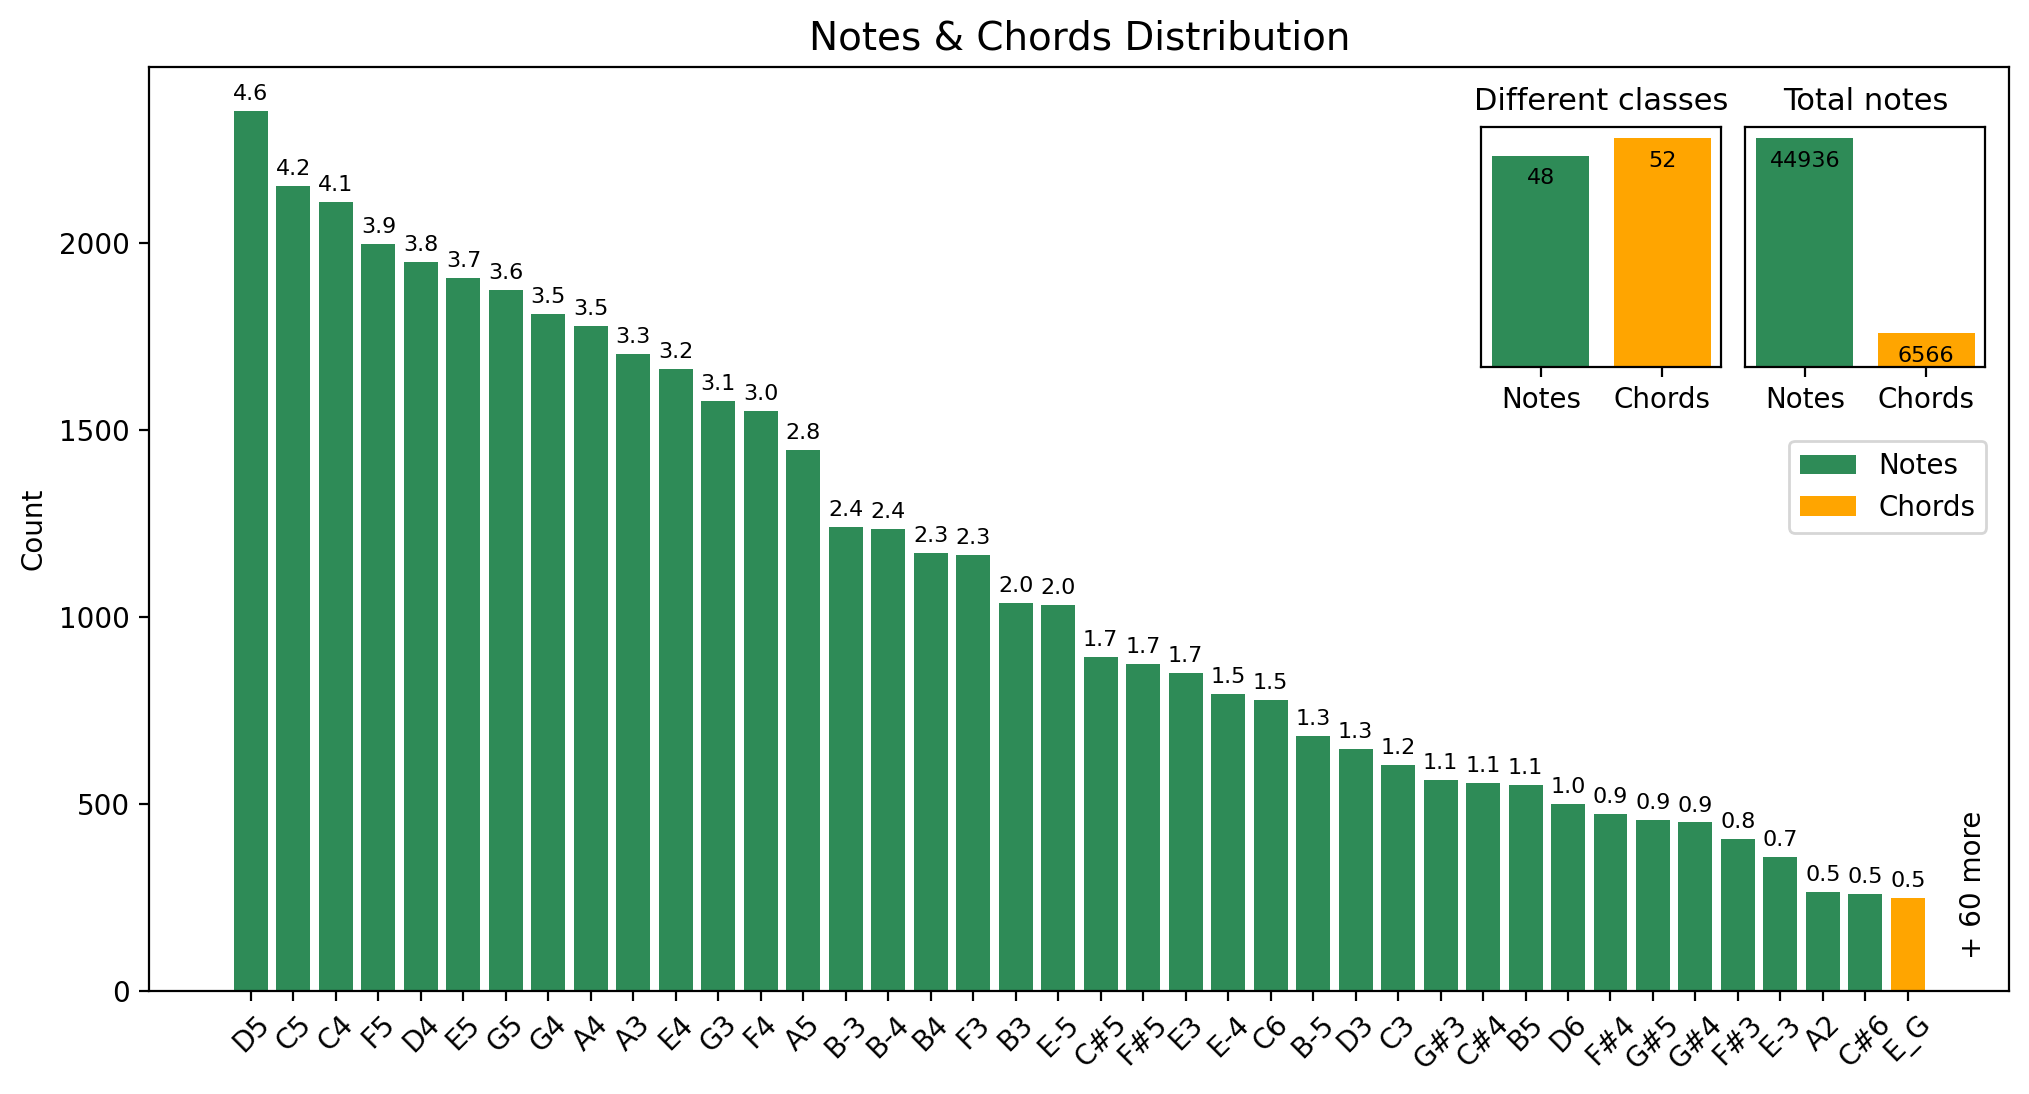


>> Building model


2023-05-07 22:25:49.066209: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-07 22:25:52.519458: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11445 MB memory:  -> device: 0, name: NVIDIA TITAN Xp, pci bus id: 0000:06:00.0, compute capability: 6.1



>> Beginning training


2023-05-07 22:25:53.895040: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-05-07 22:25:57.623602: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8401


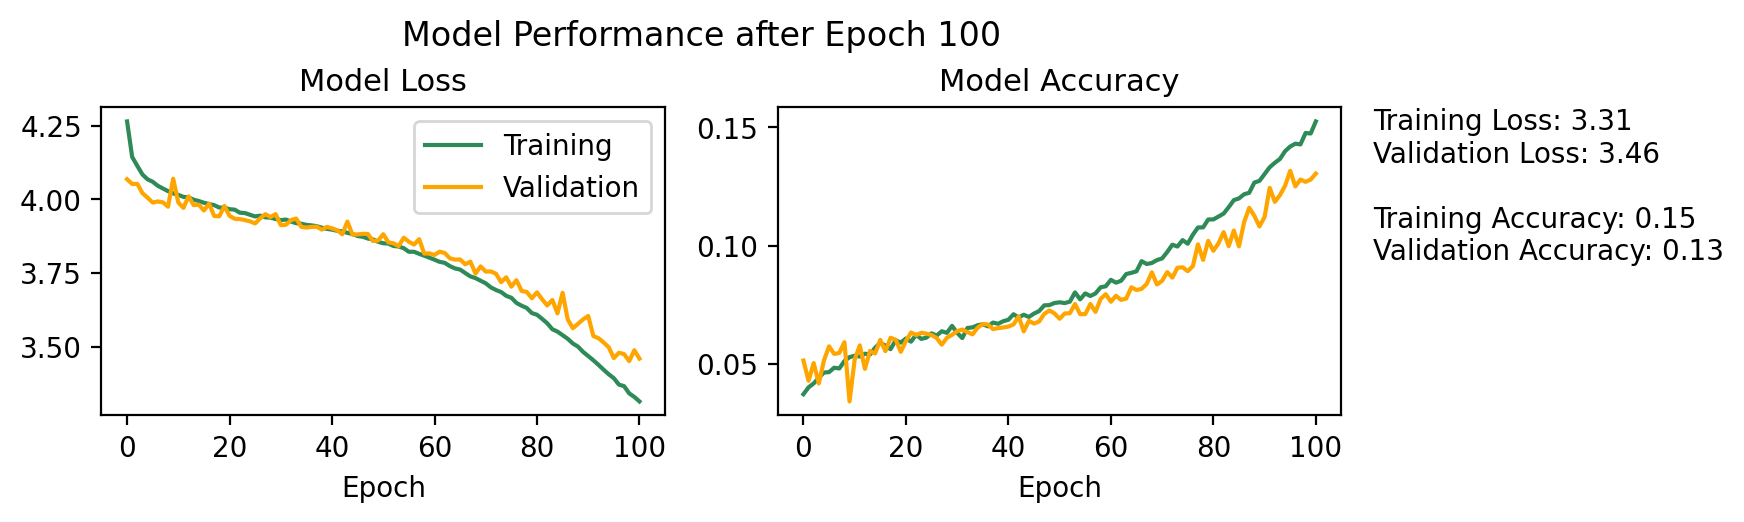

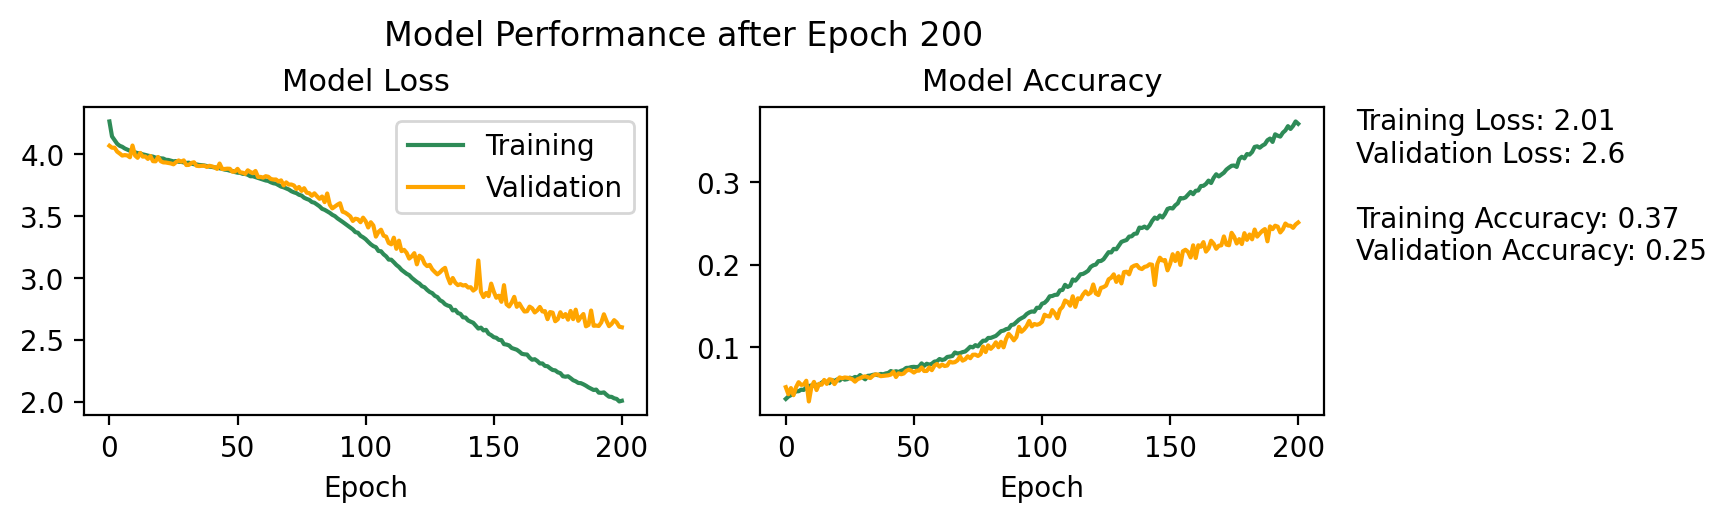

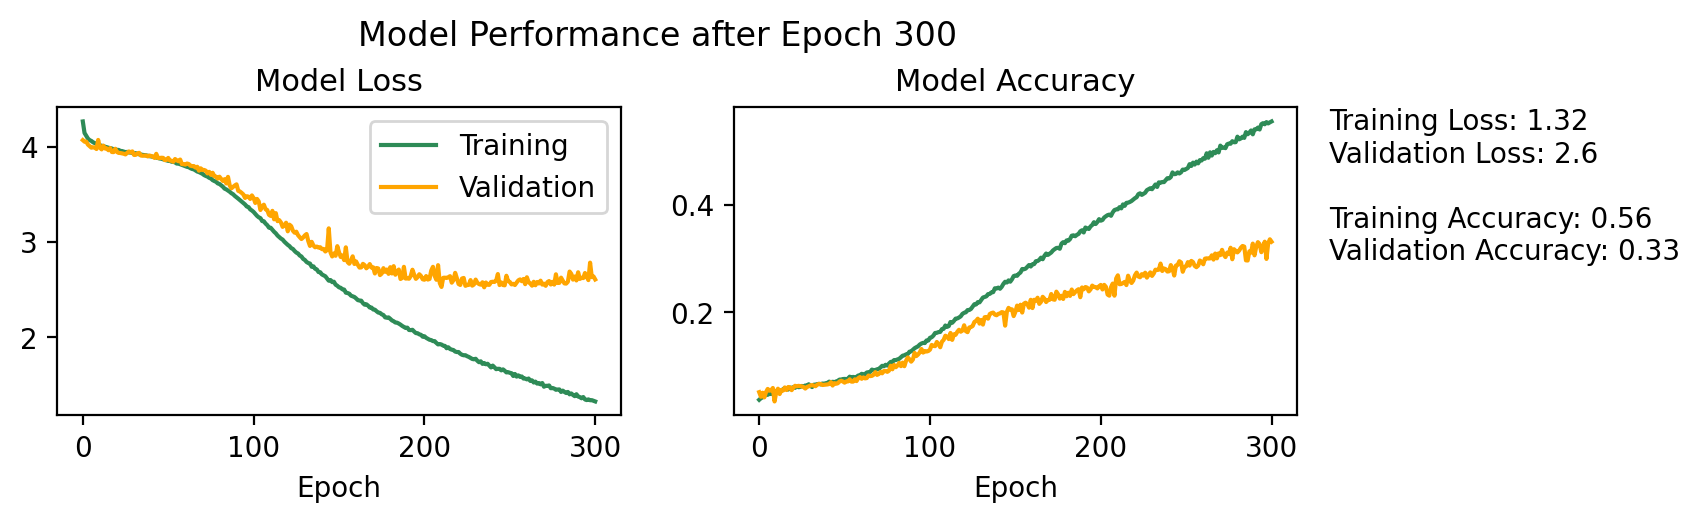

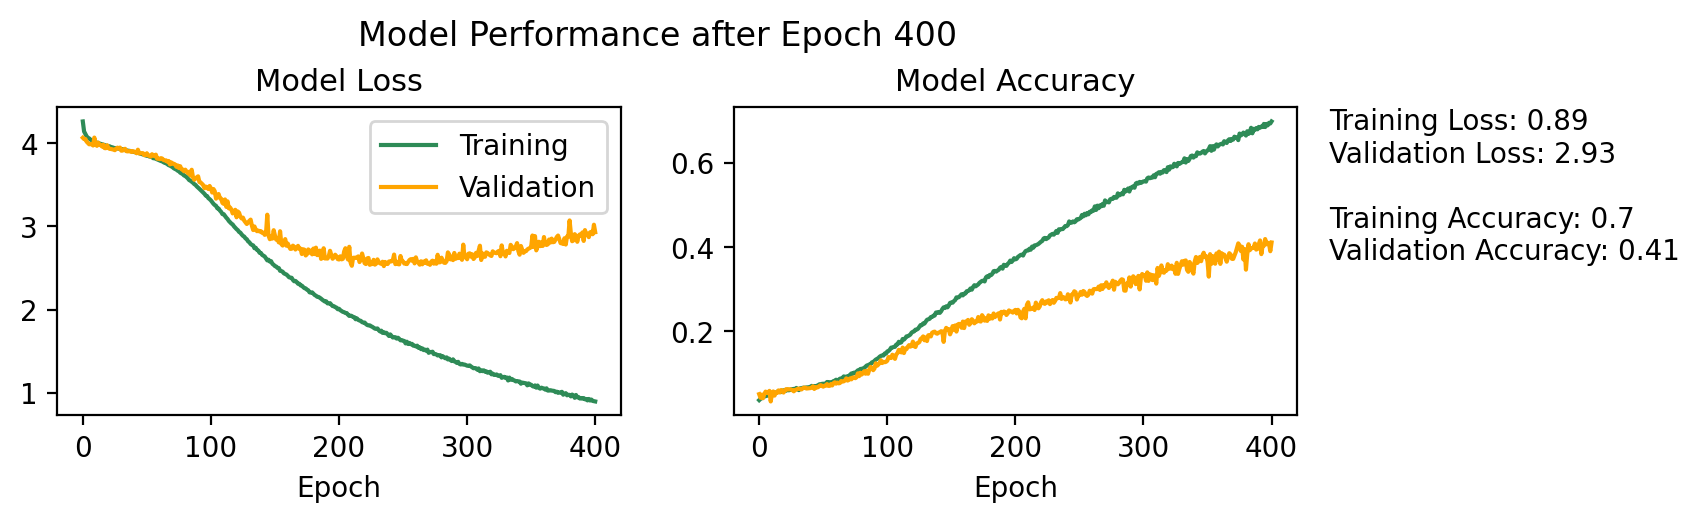

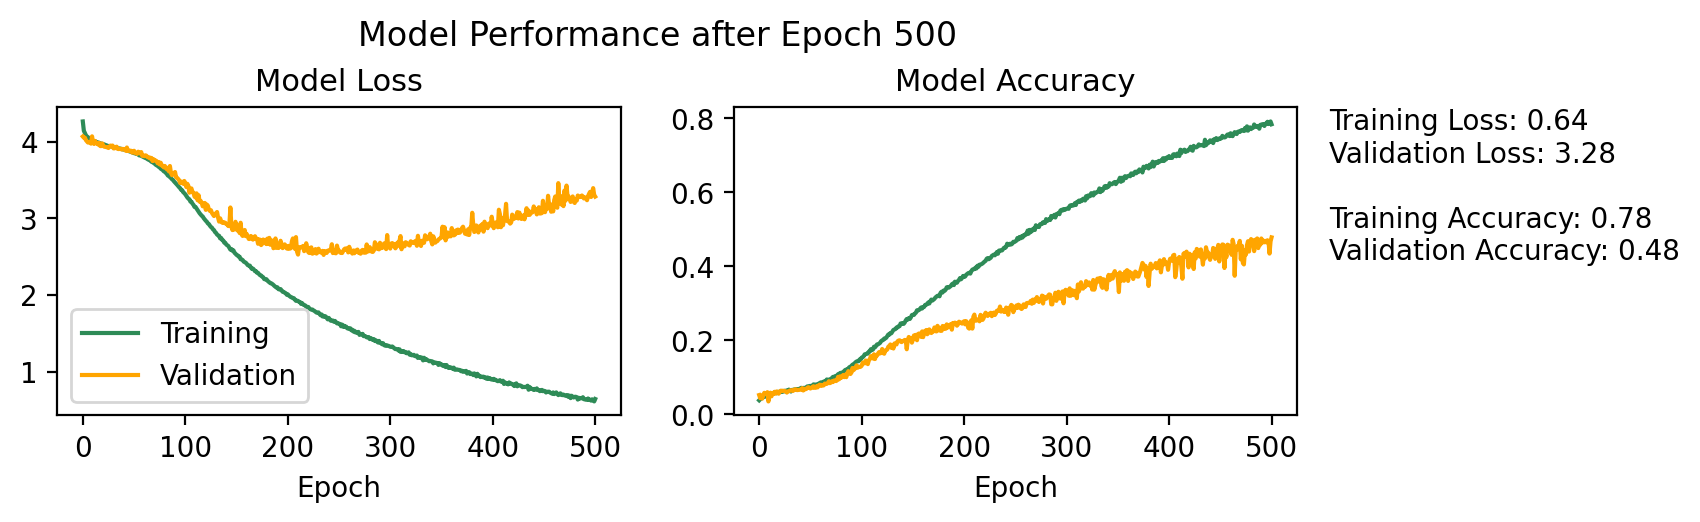

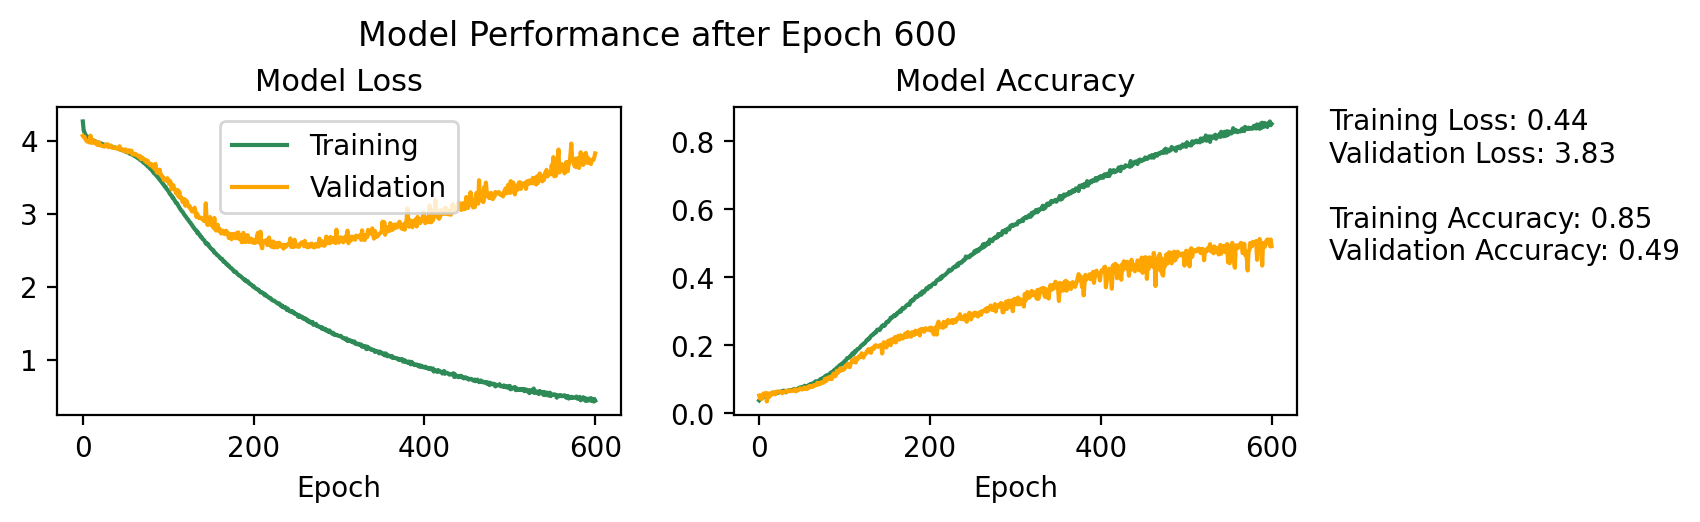

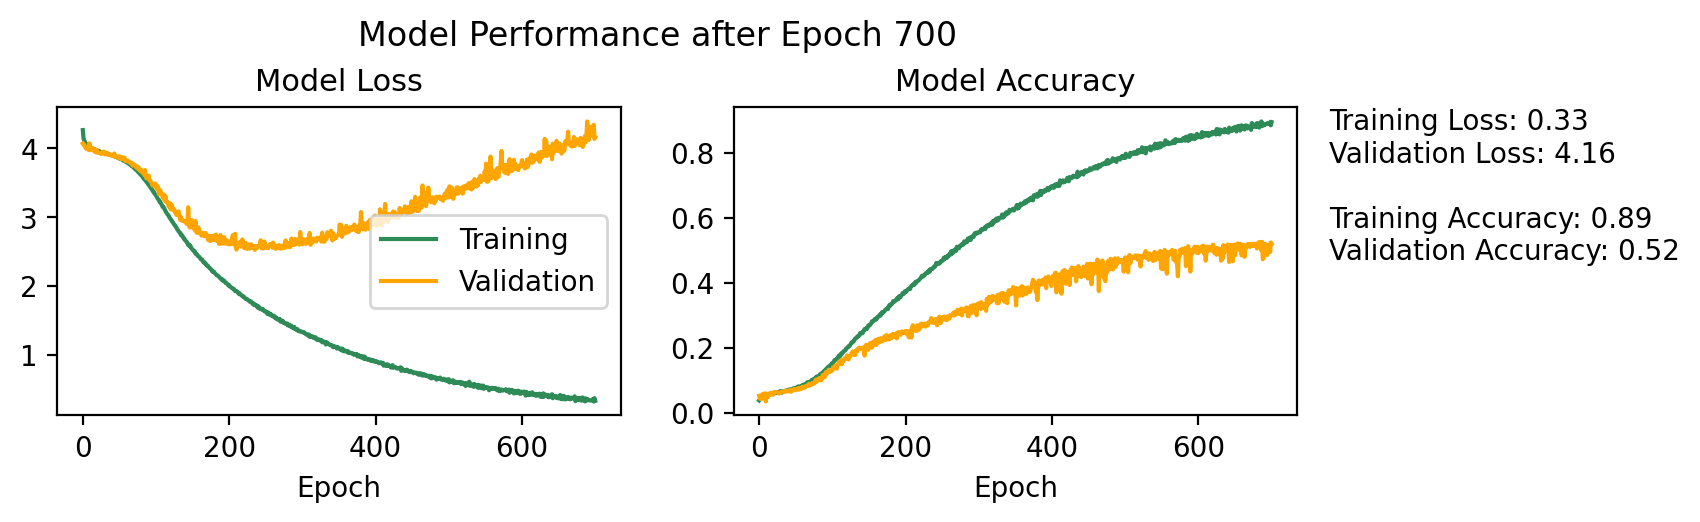

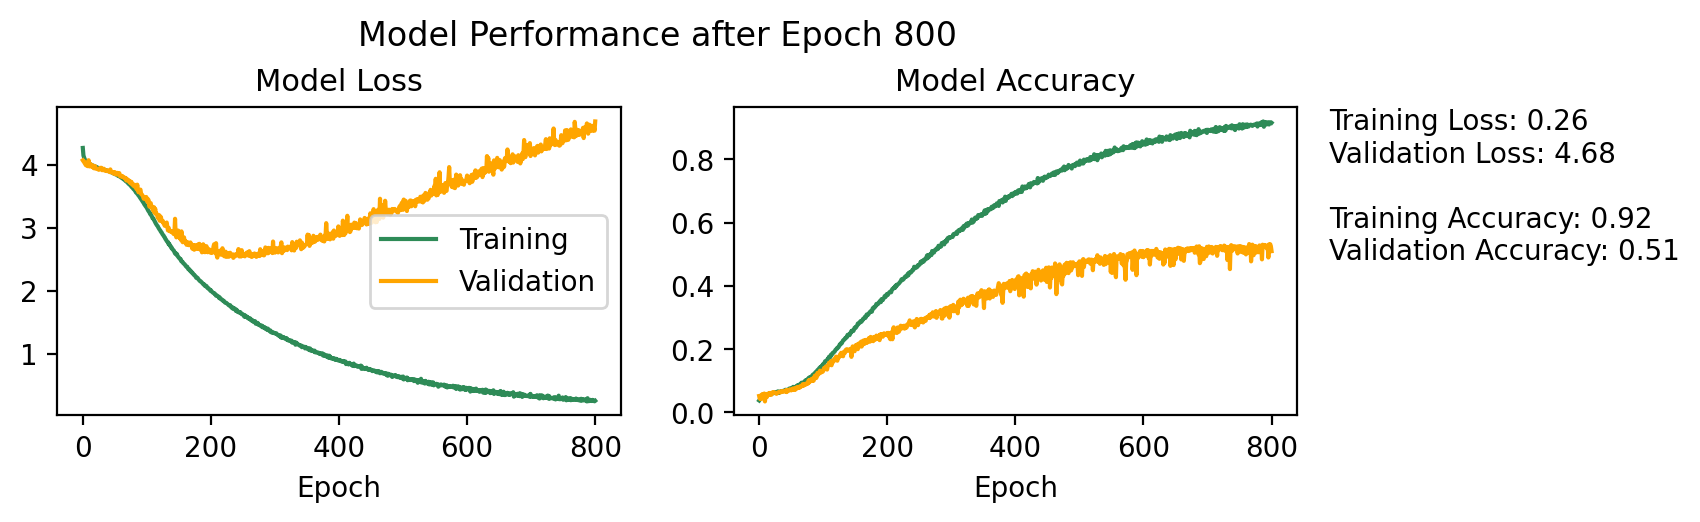

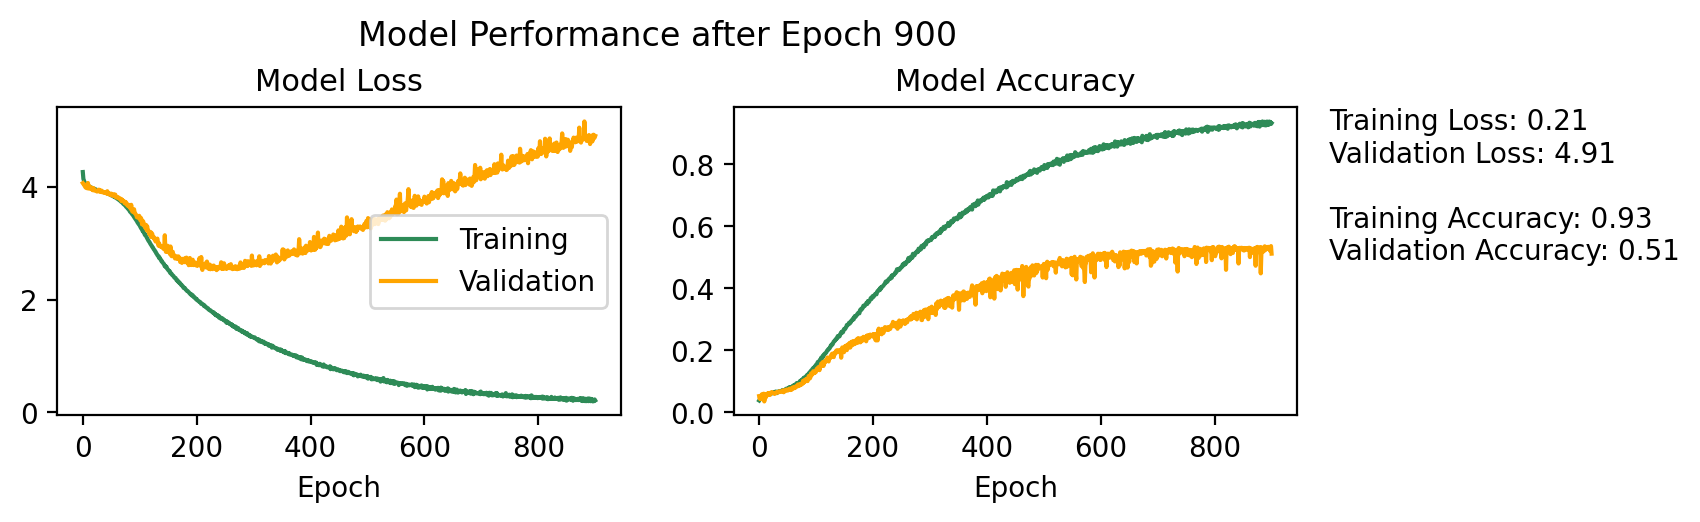

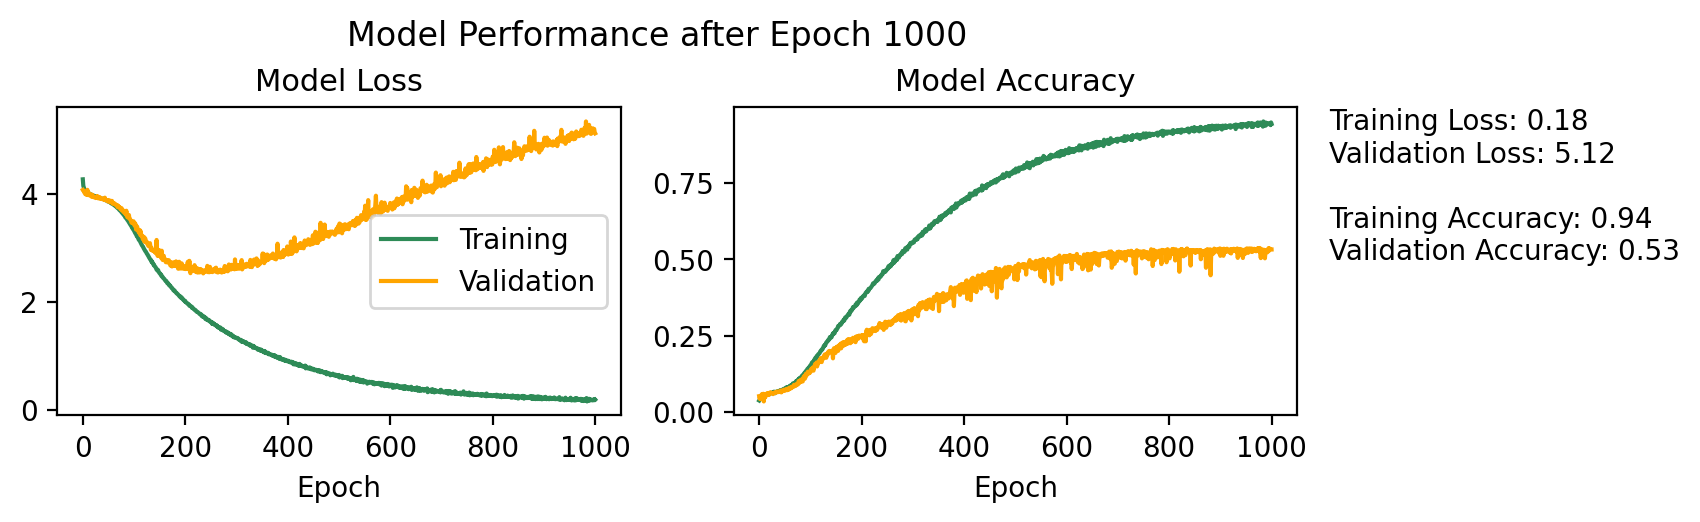


>> Finished training
Total training time: 212 minutes
Final training Loss: 0.18277141451835632
Final validation Loss: 5.116366386413574
Final training Accuracy: 0.94266277551651
Final validation Accuracy: 0.5315324068069458


In [20]:
if not load_only_functions:
    training_output = complete_lstm_training("midi_files/mozart", max_classes=100, input_length=50, batch_size=1024, plot_every_x_epochs=100, 
                                            epochs=1001, learning_rate=0.0001, only_first_part=False)

    trained_model = training_output["model"]
    note_to_int_mapping = training_output["mappings"]
    training_data = training_output["train_data"]

    trained_model.save('saved_model_mozart_1000')

<font color="blue"><b>Comment:</b></font> We can see that the model was able to achieve a training accuracy of 94% and a validation accuracy of 53%. We considered this a good result especially as there is a high number of possible notes for each step and music as a whole is not totally predictable. One interesting aspect of the training, and all similar trainings, is that the validation loss increases again after a certain amount of epochs and even surpases its starting value. We assume that this is because the model is overfitting on the training data. Despite overfitting, the accuracy of the validation data still increased slowly till the end of training. Because we didnt see a decrease in validation accuracy, we decided to let the model reach its maximum training accuracy, which it did at roughly 1000 epochs with a learning rate of 0.0001. Why we didnt choose a higher learning rate will be discussed below.

# Generating new Music

After training, the model should have learned to predict the note or chord after *listening* to a sequence of tones. If the model is good at this task, it means that it does know what sequence of tones *sounds right™* (given the training data has the same property).

To generate new music, you just need to let the network *listen* to a sequence of tones (the seed) and ask for the next note or chord. Then, append this predicted tone to the end of the seed (and remove the first entry), feed the new seed into the network and get for the next tone.

<img alt="rnn generation" src="data:image/svg+xml,%3C%3Fxml%20version%3D%221.0%22%20encoding%3D%22UTF-8%22%20standalone%3D%22no%22%3F%3E%0D%0A%3C%21DOCTYPE%20svg%20PUBLIC%20%22-%2F%2FW3C%2F%2FDTD%20SVG%201.1%2F%2FEN%22%20%22http%3A%2F%2Fwww.w3.org%2FGraphics%2FSVG%2F1.1%2FDTD%2Fsvg11.dtd%22%3E%0D%0A%3Csvg%20width%3D%22100%25%22%20height%3D%22100%25%22%20viewBox%3D%220%200%202953%20591%22%20version%3D%221.1%22%20xmlns%3D%22http%3A%2F%2Fwww.w3.org%2F2000%2Fsvg%22%20xmlns%3Axlink%3D%22http%3A%2F%2Fwww.w3.org%2F1999%2Fxlink%22%20xml%3Aspace%3D%22preserve%22%20xmlns%3Aserif%3D%22http%3A%2F%2Fwww.serif.com%2F%22%20style%3D%22fill-rule%3Aevenodd%3Bclip-rule%3Aevenodd%3Bstroke-linecap%3Around%3Bstroke-linejoin%3Around%3Bstroke-miterlimit%3A1.5%3B%22%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C506.827%2C26%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28208%2C124%2C127%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C483.827%2C48%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EC4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C588.827%2C26%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28208%2C124%2C127%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C566.827%2C48%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EE4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C670.827%2C26%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28208%2C124%2C127%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C648.827%2C48%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EC6%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C752.827%2C26%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28208%2C124%2C127%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C730.827%2C48%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EB4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C588.827%2C166%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28208%2C124%2C127%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C566.827%2C188%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EE4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C670.827%2C166%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28208%2C124%2C127%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C648.827%2C188%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EC6%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C752.827%2C166%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28208%2C124%2C127%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C730.827%2C188%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EB4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C834.827%2C166%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28151%2C208%2C119%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C805.827%2C188%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EB-4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C934.827%2C26%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28151%2C208%2C119%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C905.827%2C48%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EB-4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1576.83%2C26%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28151%2C208%2C119%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1547.83%2C48%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EB-4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1576.83%2C166%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28151%2C208%2C119%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1547.83%2C188%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EB-4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C670.827%2C306%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28208%2C124%2C127%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C648.827%2C328%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EC6%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C752.827%2C306%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28208%2C124%2C127%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C730.827%2C328%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EB4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C834.827%2C306%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28151%2C208%2C119%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C805.827%2C328%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EB-4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C916.827%2C306%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28151%2C208%2C119%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C893.827%2C328%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EG4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1017.83%2C166%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28151%2C208%2C119%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C994.827%2C188%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EG4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1659.83%2C166%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28151%2C208%2C119%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1636.83%2C188%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EG4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1576.83%2C306%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28151%2C208%2C119%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1547.83%2C328%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EB-4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1659.83%2C306%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28151%2C208%2C119%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1636.83%2C328%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EG4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C752.827%2C446%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28208%2C124%2C127%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C730.827%2C468%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EB4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C834.827%2C446%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28151%2C208%2C119%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C805.827%2C468%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EB-4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C916.827%2C446%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28151%2C208%2C119%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C893.827%2C468%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EG4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C998.827%2C446%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28151%2C208%2C119%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C978.827%2C468%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EA4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1095.83%2C306%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28151%2C208%2C119%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1076.83%2C328%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EA4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1742.83%2C306%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28151%2C208%2C119%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1723.83%2C328%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EA4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1576.83%2C436%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28151%2C208%2C119%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1547.83%2C458%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EB-4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1659.83%2C436%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28151%2C208%2C119%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1636.83%2C458%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EG4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1742.83%2C436%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28151%2C208%2C119%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1824.83%2C436%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28151%2C208%2C119%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1723.83%2C458%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EA4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%280.50007%2C0%2C0%2C1%2C796.352%2C-373.498%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M275.736%2C494.2L275.736%2C479.848L374.611%2C479.848L374.611%2C466.521L415.61%2C487.024L374.611%2C507.526L374.611%2C494.2L275.736%2C494.2Z%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%280.50007%2C0%2C0%2C1%2C878.844%2C-233.498%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M275.736%2C494.2L275.736%2C479.848L374.611%2C479.848L374.611%2C466.521L415.61%2C487.024L374.611%2C507.526L374.611%2C494.2L275.736%2C494.2Z%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%280.50007%2C0%2C0%2C1%2C957.352%2C-93.4975%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M275.736%2C494.2L275.736%2C479.848L374.611%2C479.848L374.611%2C466.521L415.61%2C487.024L374.611%2C507.526L374.611%2C494.2L275.736%2C494.2Z%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%280.50007%2C0%2C0%2C1%2C1039.35%2C46.5025%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M275.736%2C494.2L275.736%2C479.848L374.611%2C479.848L374.611%2C466.521L415.61%2C487.024L374.611%2C507.526L374.611%2C494.2L275.736%2C494.2Z%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C205.216%2C-531.178%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22517.599px%22%20y%3D%22569.231px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A37.5px%3B%22%3Eseed%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C460.216%2C-531.178%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22517.599px%22%20y%3D%22569.231px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A37.5px%3B%22%3Eprediction%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C745.116%2C-32.5778%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22517.599px%22%20y%3D%22569.231px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A62.5px%3B%22%3E...%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1406.52%2C-42.2273%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22517.599px%22%20y%3D%22569.231px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A62.5px%3B%22%3E...%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%282.01933e-16%2C-0.71323%2C4.12755%2C1.16899e-15%2C-1631.49%2C328.808%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22353.101px%22%20y%3D%22598.079px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A79.542px%3B%22%3E%7D%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%282.01933e-16%2C-0.71323%2C4.12755%2C1.16899e-15%2C-561.494%2C328.808%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22353.101px%22%20y%3D%22598.079px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A79.542px%3B%22%3E%7D%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%282.01933e-16%2C-0.71323%2C1.04117%2C2.94875e-16%2C458.116%2C328.808%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22353.101px%22%20y%3D%22598.079px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A79.542px%3B%22%3E%7D%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1123.22%2C-531.178%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22517.599px%22%20y%3D%22569.231px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A37.5px%3B%22%3Egenerated%20comp%3Ctspan%20x%3D%22777.062px%20%22%20y%3D%22569.231px%20%22%3Eo%3C%2Ftspan%3Esition%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%284.14714e-16%2C-6.7728%2C6.7728%2C4.14714e-16%2C1280.62%2C11356.2%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M1672.64%2C28.679L1593.64%2C28.904%22%20style%3D%22fill%3Anone%3Bstroke%3Ablack%3Bstroke-width%3A0.15px%3Bstroke-dasharray%3A1.48%2C1.48%2C0%2C0%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%3C%2Fsvg%3E%0D%0A" />

#### Tasks:
* Implement the procedure described above to generate a sequence of 500 notes or chords.

#### Hints:
* Use a sample from the training data as the seed. This does not mean that the network will generate the same melody as in the song the seed is chosen from. As we use the prediction in the next round to predict the next tone, imperfections in the network's predictions will propagate and thus the generated output will *drift* from the seed more and more.
* Do not include the seed in your generated song (that would be cheating, right?)

<font color="blue"><h5>FUNCTION: Generate new music</h5></font>
This function creates new music tracks by performing looped inference on a trained model. Returns a list of note names. The initial sequence is also returned in a converted state if the user wants to combine the two sequences to see how the generated music differs from its input sequence.
* `model` = A trained keras model used for inference
* `start_sequence` = The start sequence for the inference. Needs to be a normalised note sequence. Reshaping is handeled by the function if necessary
* `note_to_int_mapping` = The mapping used in the creating of the training data for the model
* `length` = The number of notes the new track should contain

In [20]:
def generate_new_music(model, start_sequence, note_to_int_mapping, length):
    int_to_note_mapping = {y: x for x, y in note_to_int_mapping.items()}  # Flip mapping for easier use
    generated_sequence = []  # List for storing generated notes
    num_classes = model.layers[0].input_shape[1]  # Get number of classes by looking at model input
    
    # Reshape input sequence if necessary
    if len(start_sequence.shape) != 3:
        start_sequence = start_sequence[:num_classes].reshape(1, num_classes, 1)
    moving_sequence = copy.deepcopy(start_sequence)

    # Model Inference = Create music
    for i in range(length):
        prediction = model.predict([moving_sequence])[0].tolist()
        pred_note_name = int_to_note_mapping[prediction.index(max(prediction))]
        moving_sequence = np.delete(moving_sequence, 0, axis=1) # Remove first element
        pred_norm = note_to_int_mapping[pred_note_name]/num_classes
        moving_sequence = np.append(moving_sequence, np.array([[pred_norm]]).reshape(1, 1, 1), axis=1)
        generated_sequence.append(pred_note_name)

    # Convert input sequence
    start_seq_flat = np.ndarray.flatten(start_sequence*num_classes)
    start_seq_flat = start_seq_flat.astype(int)
    start_seq_notes = [int_to_note_mapping[i] for i in start_seq_flat]
        
    return start_seq_notes, generated_sequence

In [32]:
if not load_only_functions:
    input_sequence = random.choice(training_data)  # Use a random training sequence as input
    start_sequence, generated_sequence = generate_new_music(trained_model, input_sequence, note_to_int_mapping, length=500)

    print("Input Sequence:\n", start_sequence)
    print("Generated Sequence:\n", generated_sequence)

Input Sequence:
 ['E-_C', 'E4', 'G_E-', 'C#3', 'A5', 'C#3', 'G_E-', 'E4', 'E-_C', 'D_B', 'G_E-', 'E-_C', 'E4', 'G_E-', 'C#3', 'A5', 'C#3', 'E4', 'G_E-', 'E-_C', 'E4', 'G_E-', 'E4', 'G_E-', 'E-_C', 'E_E', 'G_E-', 'B-_G', 'G_E-', 'D_B-', 'A_G', 'A5', 'C#3', 'A5', 'C#3', 'D_B-', 'E4', 'D_B-', 'C5', 'C5', 'G_B', 'B_D', 'F_F', 'G_B', 'B_D', 'G_B', 'E_C', 'F_F', 'A5', 'E_C']
Generated Sequence:
 ['E_E', 'E_E', 'A_A', 'C#_A', 'E4', 'A4', 'E4', 'A4', 'E4', 'E4', 'E4', 'E4', 'E4', 'E4', 'E4', 'E4', 'E-4', 'C#4', 'B_D', 'F#_A', 'B_G', 'G3', 'C4', 'E4', 'C4', 'G3', 'E4', 'G3', 'E4', 'D3', 'E4', 'F#3', 'B_D', 'B-_D', 'B_D', 'E-5', 'F#5', 'A3', 'F3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'D3', 'D3', 'D3', 'D3', 'E3', 'E3', 'E3', 'E3', 'E3', 'D3', 'D3', 'E3', 'E3', 'E3', 'E3', 'D3', 'A3', 'A3', 'A3', 'D3', 'D3', 'D3', 'E3', 'E3', 'E3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'D3', 'D3', 'D3', 'E3', 'E3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'D3', 'D3', 'E3', 

<font color="blue"><h5>Analysis</h5></font> 
When testing with a random input of the training dataset (as described in the task) we can see that the model creates a diverse set of notes and chords for the first half of the sequence. However, looking at the end of the generated sequence, we can see that the diversity decreases and the model defaults to a few notes, in this case mainly A3, E3, D3. We first assumed that these notes must be the most common notes in the training data, however looking at the distribution plot above, we can see that this is not the case. while these three notes are still used frequently, they are not even in the top 5 notes in terms of frequency. Another case could be that these notes are often played together for longer periods of time when occuring hence the frequent use of these notes by our model in the second half. <br>
We tested multiple random input sequences from the training data and got similar results to the one displayed. The other generated tracks as well as this one can be accessed in the folder **generated_music/track_mozart_1000/*.mid**

Now that you have a list of tones in integer representation, you need to convert it back to ```music21.note.Note``` and ```music21.chord.Chord``` objects that are arranged in a flat midi-stream.

#### Tasks:
* convert the generated song to a ```music21.stream.Stream``` by first mapping each int back to the string representation and then creating notes and chords.

#### Hints:
* for notes you can simply pass the string representation to the ```music21.note.Note``` constructor 
* for chords you first need to split the string into single notes and assemble them into a ```music21.chord.Chord```
* as our model is not able to predict any property other than the next note/chord, we can only use a fixed tone duration. Give each chord/note a fixed offet of $\frac{1}{2}$ bar.
* specify a [```music21.Instrument()```](http://web.mit.edu/music21/doc/moduleReference/moduleInstrument.html#piano) to each note

You can now use the ```show()``` method of the stream to listen to the generated masterpiece or save it to disk for later enjoyment using the ```write()``` method.

<font color="blue"><b>Comment:</b></font> The function for converting note names back to a Stream object was already defined in a previous cell in this notebook, because we wanted to make sure the notes were extracted correctly. See function `create_midi`. The generated midi files can be found, as described above, at **generated_music/track_mozart_1000/*.mid**

In [33]:
if not load_only_functions:
    # Create Midi
    # generated_stream = create_midi(start_sequence + generated_sequence)
    generated_stream = create_midi(generated_sequence)
    generated_stream.show("midi")

    # Save as file
    generated_stream.write("midi", f"./generated_music/track_mozart_1000_{datetime.now().strftime('%d_%m_%Y_%H_%M')}.mid")

<font color="blue"><h4>Comparison of Hyperparameter configurations</h4></font> 
<font color="blue"><h5>TEST: Higher learning rate</h5></font> 
Below, we show an example of training with the standard learning rate of the RMSprop optimizer which is 0.001. We can see that the model can't overcome the threshold of a 5% training accuracy. Later examination showed that a mode collapse is happening during training as the model always defaults to the note with the highest frequency in the training data. This was a big problem for us in the beginning as we first tried to tweak other hyperparameters before discovering that the solution to the problem is reducing the learning rate by a substantial amount. Looking at the accuracy training plot below, we can see that the model has some moments where it tries to experiment with other notes and the training accuracy briefly jumps above the mode collapse, however none of these tries were successfull. We learned from this experience that the learning rate is also an important hyperparameter which could prevent the model from learning at all if it is set too high.

>> Creating training data
Loaded notes from 21 midi files
Total number of notes: 55802
Number of unique notes: 638
Removed 4300 notes to get to 100 classes (51502 total notes remaining)
X_train: (41160, 50, 1) | y_train: (41160, 100) | X_test: (10291, 50, 1) | y_test: (10291, 100)

>> Building model

>> Beginning training


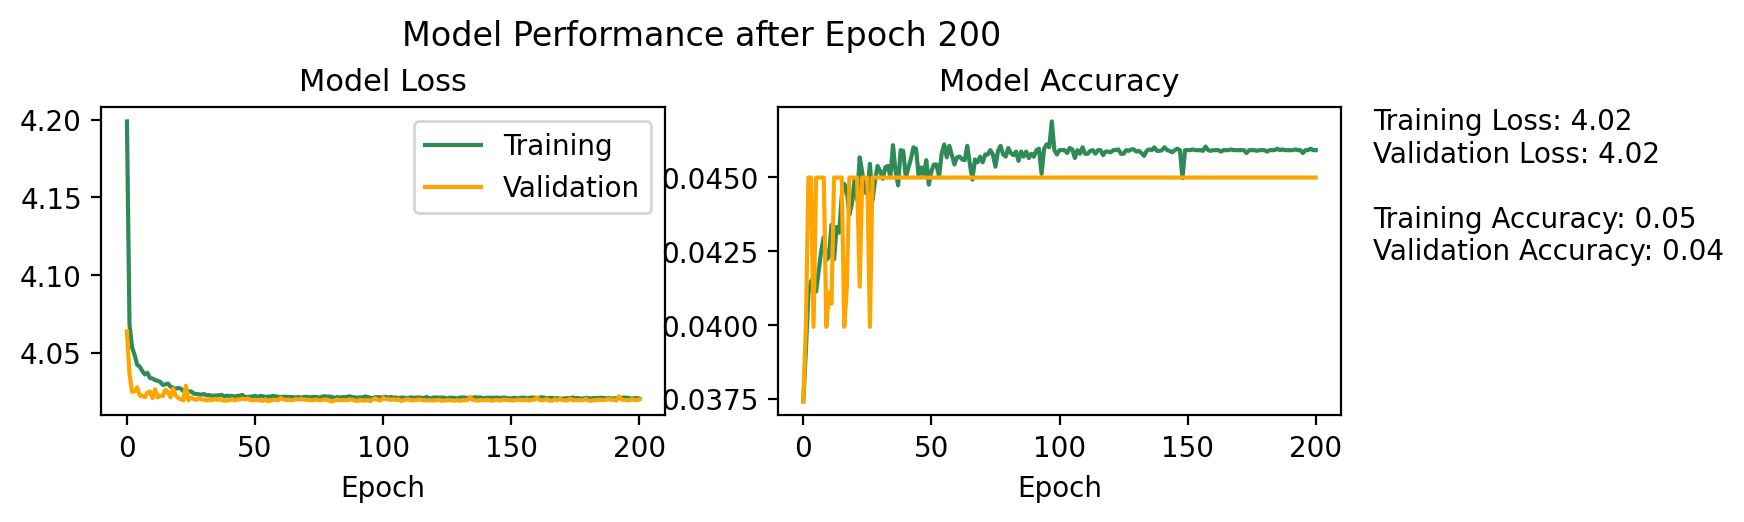


>> Finished training
Total training time: 42 minutes
Final training Loss: 4.020559310913086
Final validation Loss: 4.020027160644531
Final training Accuracy: 0.04591836780309677
Final validation Accuracy: 0.044990766793489456


In [22]:
high_lr_training_output = complete_lstm_training("midi_files/mozart", max_classes=100, input_length=50, batch_size=1024, plot_every_x_epochs=200, 
                                                 epochs=201, learning_rate=0.001, only_first_part=False, plot_note_dist=False)

In [34]:
if not load_only_functions:
    input_sequence = random.choice(high_lr_training_output["train_data"])  # Use a random training sequence as input
    start_sequence, generated_sequence = generate_new_music(high_lr_training_output["model"], input_sequence, high_lr_training_output["mappings"], length=500)

    print("Input Sequence:\n", start_sequence)
    print("Generated Sequence:\n", generated_sequence)

    # Save as file
    generated_stream = create_midi(generated_sequence)
    generated_stream.write("midi", f"./generated_music/mozart_high_learn_rate_{datetime.now().strftime('%d_%m_%Y_%H_%M')}.mid")

Input Sequence:
 ['G_B-', 'G_A', 'G_B-', 'G_D', 'G_A', 'G_D', 'C_D', 'E_A', 'C_D', 'D_E', 'G_A', 'E_A', 'C_D', 'D_E', 'E_A', 'G_D', 'E-6', 'D4', 'E_A', 'C_D', 'C_D', 'C_D', 'E_A', 'C_D', 'D_E', 'D_E', 'G_A', 'E_A', 'C_D', 'E_A', 'G_D', 'E-6', 'F#4', 'C#5', 'D_F', 'C_D', 'D_E', 'D4', 'D_E', 'D4', 'B4', 'C_D', 'G_B-', 'G_A', 'G_B-', 'G_D', 'G_A', 'G_D', 'C_D', 'G_B-']
Generated Sequence:
 ['D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5

<font color="blue"><b>Comment:</b></font> As described above we can see that the output of the model is always the most frequent tone in the training dataset, which in this case is D5.

<font color="blue"><h5>TEST: Shorter input sequences</h5></font>
We also experimented with changing the input sequence length of the model. This move was surprisingly successfull. We will compare this model to the first model described in the notebook, which had a sequence length of 50 and a learning rate of 0.0001.<br>
Firstly with a smaller input sequence, we could increase the learning rate again to 0.001, which was very practical, as training with a learning rate of 0.0001 took a very long time. <br>
The validation accuracy also increased from 53% to 69%. With a creative task like creating music, this of course does not guarantee better model performance, but nevertheless is a good indicator. <br>
The "quality" of the generated music is similar with both models in our opinion, however we noticed, that the short sequence model was not collapsing as much in the later parts of the track and created more divese notes. In comparison, the longer sequence model was defaulting to 3 notes after a while, as described previously. <br><br>
We concluded from this test, that the sequence length can be shortened (In our case from 50 to 20) without performance loss of the model. Of course, potential long term connection would get lost in this case, however we didnt notice any of these long term dependencies really applied by the longer sequence model. <br><br>
The results of the shorter sequence model can be found at **generated_music/mozart_short_seq/*.mid**

>> Creating training data
Loaded notes from 21 midi files
Total number of notes: 55802
Number of unique notes: 638
Removed 4300 notes to get to 100 classes (51502 total notes remaining)
X_train: (41184, 20, 1) | y_train: (41184, 100) | X_test: (10297, 20, 1) | y_test: (10297, 100)

>> Building model

>> Beginning training


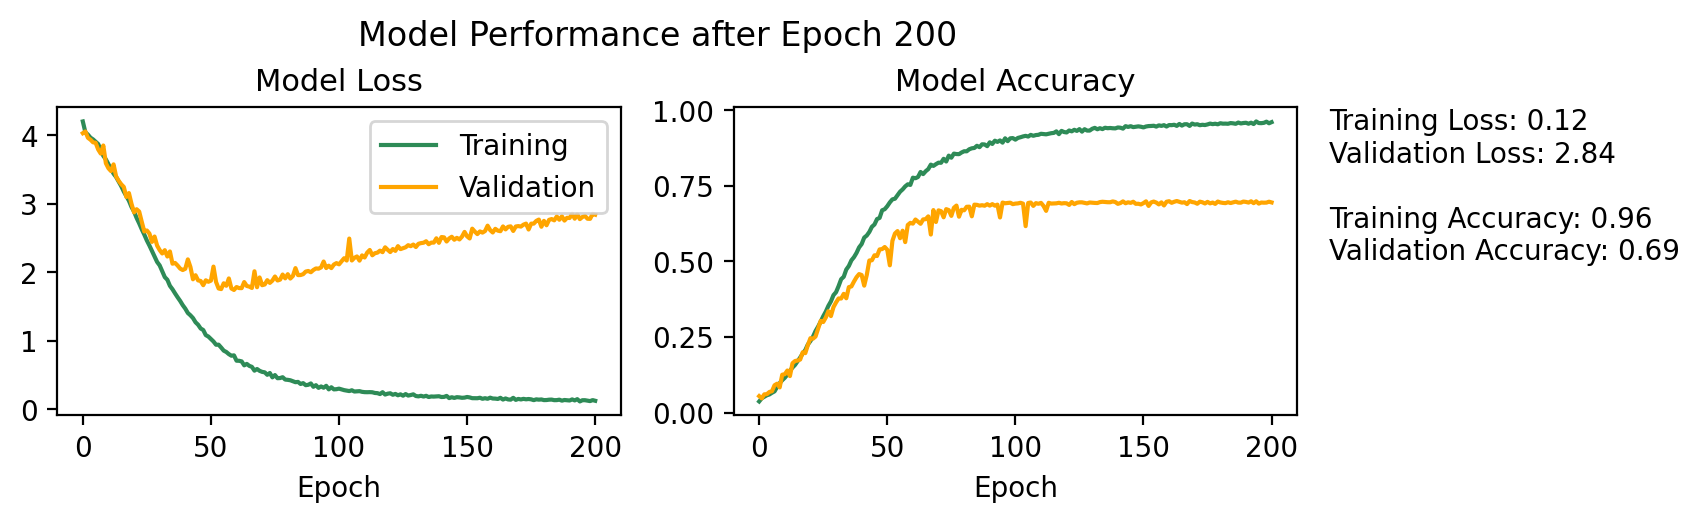


>> Finished training
Total training time: 19 minutes
Final training Loss: 0.12330643832683563
Final validation Loss: 2.841604232788086
Final training Accuracy: 0.9600573182106018
Final validation Accuracy: 0.6946683526039124


In [29]:
short_seq_training_output = complete_lstm_training("midi_files/mozart", max_classes=100, input_length=20, batch_size=1024, plot_every_x_epochs=200, 
                                                   epochs=201, learning_rate=0.001, only_first_part=False, plot_note_dist=False)

In [33]:
if not load_only_functions:
    input_sequence = random.choice(short_seq_training_output["train_data"])  # Use a random training sequence as input
    start_sequence, generated_sequence = generate_new_music(short_seq_training_output["model"], input_sequence, short_seq_training_output["mappings"], length=500)

    print("Input Sequence:\n", start_sequence)
    print("Generated Sequence:\n", generated_sequence)

    # Save as file
    generated_stream = create_midi(generated_sequence)
    generated_stream.write("midi", f"./generated_music/mozart_short_seq_{datetime.now().strftime('%d_%m_%Y_%H_%M')}.mid")

Input Sequence:
 ['A_F', 'G#3', 'D_E', 'G#3', 'E4', 'E-6', 'B_B', 'D4', 'F#4', 'G#3', 'B_B', 'G#5', 'E4', 'B_B', 'F_D', 'E-6', 'E-6', 'B3', 'A4', 'E-6']
Generated Sequence:
 ['G4', 'G5', 'D_B', 'G4', 'C3', 'B_G', 'G5', 'C3', 'C3', 'E-_G', 'G3', 'G5', 'B-2', 'B2', 'B-2', 'G5', 'B-2', 'B2', 'E-4', 'B5', 'F5', 'A5', 'B-2', 'B2', 'E-_G', 'B-2', 'E-_G', 'G3', 'G5', 'B-2', 'B-2', 'G5', 'G5', 'B2', 'E-_G', 'G5', 'B-2', 'B-2', 'B2', 'G2', 'B2', 'B-2', 'E-_G', 'E-_G', 'A5', 'C6', 'G3', 'E-6', 'A5', 'G5', 'G5', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'E-_G', 'E_G', 'C3', 'B-3', 'E-_G', 'E-_G', 'E-6', 'F5', 'G5', 'B-2', 'E-_G', 'E-3', 'E-_G', 'F5', 'B-3', 'D3', 'G5', 'C3', 'C3', 'B2', 'E-_G', 'G3', 'E-_G', 'E-_G', 'E-6', 'E-6', 'D6', 'G5', 'E-6', 'E-4', 'E-6', 'A5', 'D3', 'B-2', 'C3', 'E-_G', 'G5', 'B-2', 'C3', 'C3', 'B2', 'E-_G', 'G5', 'B-2', 'C3', 'B2', 'F5', 'B2', 'A_B', 'A2', 'A_B', 'B2', 'E-_G', 'C6', 'E-_G', 'A_B', 'A5', 'B2', 'B2', 'B2', 'B-2', 'C3', 'E-_G', 'D6', 'F5', 'E-_G', 'E-6', 'C6', 'E

<font color="blue"><b>Comment:</b></font> We can see, as mentioned above, that the short sequence model uses a divese set of notes, even at the furter back parts of the track.

<font color="blue"><h5>TEST: Increasing the number classes</h5></font>
We also experimented with increasing the class count, in order to limit the notes that need to be removed from the training dataset. In our case only 1269 Notes needed to be removed in comparison to 4300 when using 100 classes. Despite the training and validation accuracy looking promising (See plot below), the generated music of the model was not very diverse and collapsed to a single note further back in the track. This example showed us, that the performance metrics are not necessarily a good indicator of a model that generates creative works such as music. <br>
The generated tracks can be viewed at **generated_music/mozart_200/*.mid**

>> Creating training data
Loaded notes from 21 midi files
Total number of notes: 55802
Number of unique notes: 638
Removed 1269 notes to get to 200 classes (54533 total notes remaining)
X_train: (43601, 30, 1) | y_train: (43601, 200) | X_test: (10901, 30, 1) | y_test: (10901, 200)

>> Building model

>> Beginning training


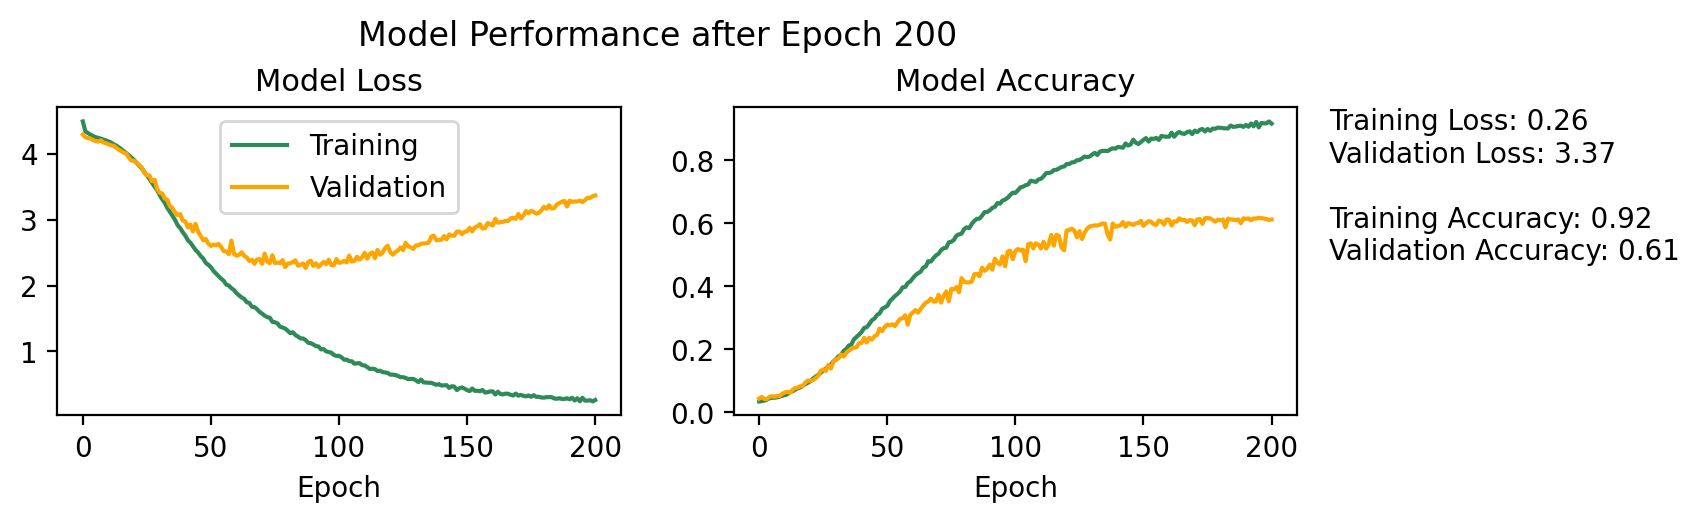


>> Finished training
Total training time: 29 minutes
Final training Loss: 0.26252129673957825
Final validation Loss: 3.3683900833129883
Final training Accuracy: 0.9167221188545227
Final validation Accuracy: 0.6124208569526672


In [23]:
class_200_training_output = complete_lstm_training("midi_files/mozart", max_classes=200, input_length=30, batch_size=1024, plot_every_x_epochs=200, 
                                                   epochs=201, learning_rate=0.0005, only_first_part=False, plot_note_dist=False)

In [28]:
if not load_only_functions:
    input_sequence = random.choice(class_200_training_output["train_data"])  # Use a random training sequence as input
    start_sequence, generated_sequence = generate_new_music(class_200_training_output["model"], input_sequence, class_200_training_output["mappings"], length=500)

    print("Input Sequence:\n", start_sequence)
    print("Generated Sequence:\n", generated_sequence)

    # Save as file
    generated_stream = create_midi(generated_sequence)
    generated_stream.write("midi", f"./generated_music/mozart_200_class_{datetime.now().strftime('%d_%m_%Y_%H_%M')}.mid")

Input Sequence:
 ['C#_B-', 'C#_B-', 'C#_B-', 'C#_B-', 'C#_B-', 'C#_B-', 'C#_B-', 'C#_B-', 'C#_B-', 'C#_B-', 'G#3', 'E-5', 'E_C#_A', 'B2', 'E_E', 'B-_B', 'B3', 'D3', 'G_D', 'E_C#_A', 'E-5', 'G#_A', 'G#3', 'G#3', 'E_G#_B', 'B_F', 'B_D', 'E_G#_B', 'G#_A', 'B3']
Generated Sequence:
 ['E-_C', 'E-_C', 'C4', 'B3', 'B3', 'E4', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'G_A', 'G_A', 'G_A', 'G_A', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5

<font color="blue"><b>Comment:</b></font> We can see, the model with a higher class count did not perform as well as expected and quickly collapsed to a single note.

<font color="blue"><h5>Further Tests conducted</h5></font>
Some other configurations we tested were: <br>
* using only the first part (Erste Stimme) of the tracks. We thought that maybe the model would perform better when only using the first part, which is often the most "melodic". Result however did not differ much from using all parts of the track.
* using `.flat.elements` instead of `.recurse()` When doing research, we discovered that the recurse method appends the second part after the first part finished. We thought that preserving the point in time notes occur in the first and second part could increase performance. By applying `flat.elements` the different parts were combined with respect to the point in time each note occurs. However, the results did not improve in comparison to using `.recurse()`. But, we suspect that there could be a performance increase if implemented differently. For example, if two notes occur at the same time in the first and second part, they are put behind each other in the flatened version. Combining those notes in one chord would preserve more of the original sound. We could not test this theory due to a lack of time.

## Further Ideas

### Simple:
* Experiment with different network architectures (GRU, Bidirectional, ...) (As training always takes a long time, this may produce limited outcome)
* Experiment with the effect of different hyperparameters. For example a very short sequence length speeds up training quite a bit, how does the generated output change (which patterns do occur) <font color="blue">= This was already done in the main part (See above)</font> 

### Advanced:
* Use a different loss function (maybe use the 'closeness' to the correct note instead of cross-entropy as the notes are not completely seperate classes, maybe employ some music theory if you have any)
* Use more input dimensions. Maybe add the duration of a tone or other properties.
* Use distributed representations of tones. In a distributed embedding space, similarities between notes could be mapped. You could learn the embedding using the skip-gram method on the note-entities.
* Use a completley different method to generate music. For example [waveGANs](https://github.com/chrisdonahue/wavegan/blob/master/README.md) generate sound using raw ausio samples. You could render your midi into wav and use the waveGAN technique or encode your data in another way and try to create your own GAN architecture.
* try to let the network predict different tone lengths (you could quantize length to e.g. 3 different lengths ($\frac{1}{4}$ bar resolution) and encode the combination of tone+duration as a single entity. As this would increase the input and output space by a factor of 3, a distributed representation of tones could help)

#### Disclaimer:
All ideas above are untested, so I can't promise a successful outcome. Of course you can always implement your own ideas.

<font color="blue"><h5>GRU Model</h5></font>
To test and compare a GRU layer architecture against the current LSTM architecture of our models, we created the function `create_gru_rnn` to create an RNN model with GRU layers.

In [27]:
def create_gru_rnn(input_length, output_size, num_gru_layers=3, gru_units=512):
    model = tf.keras.Sequential()
    
    # Add LSTM layers (LSTMs need input shape (batch_size, timesteps, features))
    for i in range(num_gru_layers):
        model.add(tf.keras.layers.GRU(input_shape=(input_length,1,), units=gru_units, return_sequences=True if i < num_gru_layers-1 else False))
        model.add(tf.keras.layers.Dropout(.3))
        
    # Add dense layers
    model.add(tf.keras.layers.Dense(units=256, activation="ReLU"))
    model.add(tf.keras.layers.Dropout(.3))
    model.add(tf.keras.layers.Dense(units=output_size, activation="softmax"))

    return model

Loaded notes from 21 midi files
Total number of notes: 55802
Number of unique notes: 638
Removed 4300 notes to get to 100 classes (51502 total notes remaining)
X_train: (41184, 20, 1) | y_train: (41184, 100) | X_test: (10297, 20, 1) | y_test: (10297, 100)


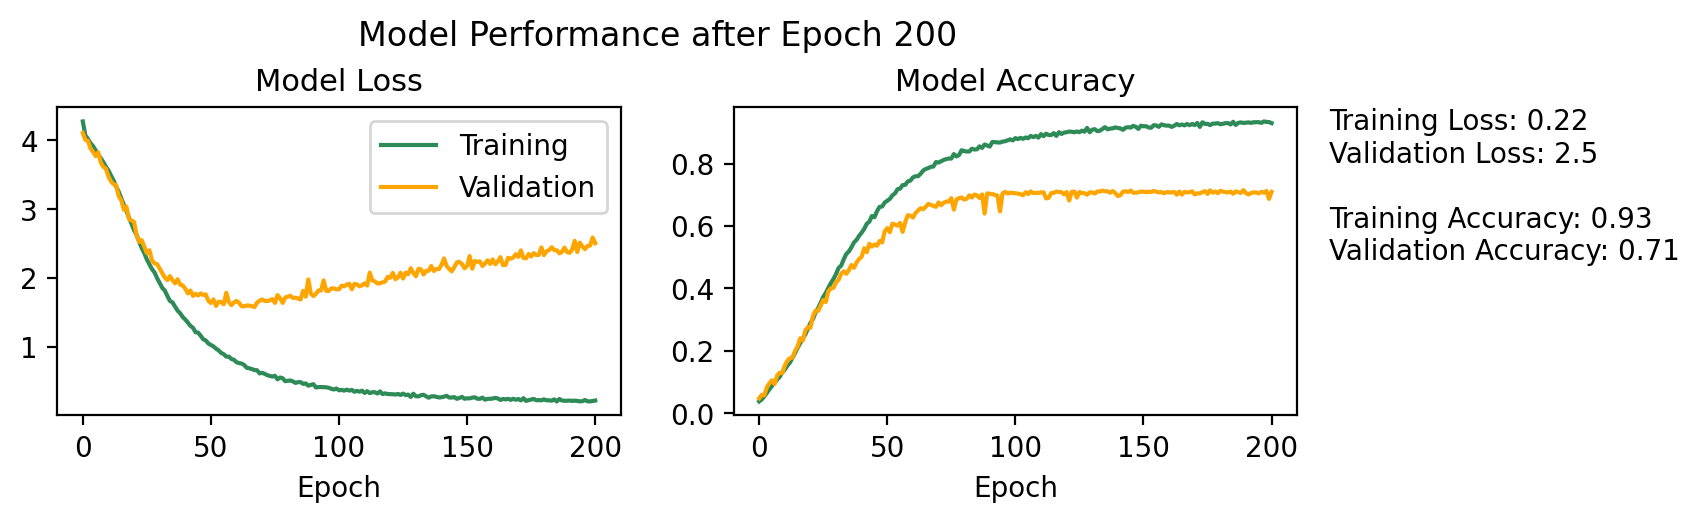

In [28]:
# Preprocess training data
all_files_notes, all_files_durations = extract_notes_from_midi_files("midi_files/mozart", flatten_list=True)
clipped_notes, clipped_durations = limit_different_notes(all_files_notes, all_files_durations, limit=100)
data, note_to_int_mapping = create_training_data(clipped_notes, seq_length=20)
X_train, X_test, y_train, y_test = train_test_split_and_reshape(data, verbose=True)

# Create and train model
gru_model = create_gru_rnn(input_length=20, output_size=100)
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
gru_model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=['accuracy'])
gru_model.fit(X_train, y_train, batch_size=1024, epochs=201, verbose=0, validation_data=(X_test, y_test), 
              callbacks=[PerfPlotCallback(200)])                          

<font color="blue"><b>Comment:</b></font> For the training of the GRU model, the same hyperparameters as the short sequence LSTM model trained above were chosen. Overall the training metrics look very similar. The validation accuracy increased slightly compared the old LSTM model from 69% to 71%.

In [33]:
if not load_only_functions:
    input_sequence = random.choice(X_train)  # Use a random training sequence as input
    start_sequence, generated_sequence = generate_new_music(gru_model, input_sequence, note_to_int_mapping, length=200)

    print("Input Sequence:\n", start_sequence)
    print("Generated Sequence:\n", generated_sequence)

    # Save as file
    generated_stream = create_midi(generated_sequence)
    generated_stream.write("midi", f"./generated_music/mozart_gru_{datetime.now().strftime('%d_%m_%Y_%H_%M')}.mid")

Input Sequence:
 ['F#4', 'C_B-', 'C3', 'B-5', 'A_F', 'A_F', 'B-5', 'C3', 'G_D', 'F_G', 'C3', 'C3', 'C6', 'C3', 'F#4', 'C_B-', 'C_B-', 'C3', 'B-5', 'C_B-']
Generated Sequence:
 ['C5', 'C5', 'B-4', 'C5', 'B-4', 'C5', 'B-4', 'C5', 'F4', 'C5', 'B-4', 'C5', 'G4', 'C5', 'C5', 'C4', 'C4', 'C5', 'C5', 'F4', 'C5', 'E-5', 'G4', 'D5', 'G4', 'F5', 'E4', 'E-5', 'B5', 'G4', 'E-5', 'E-4', 'E-4', 'C4', 'D4', 'C5', 'F4', 'G3', 'F4', 'A4', 'A4', 'E4', 'A3', 'D6', 'E6', 'E6', 'E6', 'E6', 'D6', 'E6', 'E6', 'D6', 'D6', 'F5', 'A3', 'F4', 'C5', 'F4', 'A3', 'F4', 'E4', 'F4', 'D4', 'F4', 'C5', 'F4', 'E4', 'C_D', 'A3', 'C_D', 'C5', 'F4', 'C5', 'F4', 'C5', 'F4', 'C5', 'E-5', 'D5', 'G4', 'F5', 'C5', 'A3', 'E-5', 'F4', 'F5', 'E-5', 'A4', 'D4', 'A3', 'F4', 'C5', 'F4', 'G3', 'C_D', 'F5', 'D5', 'E6', 'E6', 'A3', 'E6', 'C5', 'E4', 'F4', 'C5', 'C_D', 'C5', 'F4', 'C5', 'F4', 'C5', 'F4', 'C5', 'E-5', 'C5', 'C5', 'G3', 'C#4', 'D4', 'F5', 'F4', 'C5', 'F4', 'C5', 'F4', 'E-4', 'F4', 'A4', 'A5', 'E4', 'C5', 'C5', 'C_D', 'E4',

<font color="blue"><b>Comment:</b></font> The created tracks of the GRU model appear to have a diverse set of notes. One aspect we noticed is that the GRU model does not collapse to a just few notes at the end like many LSTM models. After listening to the produced tracks we would say that the quality is slightly better than the LSTM models. Especially in the second half because there is no collapse in note variety.

In [39]:
gru_model.save('saved_model_mozart_gru')
gru_model_X_train = X_train
gru_model_note_to_int_mapping = note_to_int_mapping

<font color="blue"><b>Comment:</b></font> Because of the good performance of GRU layers for our task, we created a complete training function for a GRU model. This function is based on the `complete_lstm_training` created in the first part of the notebook. Parameters stayed the same. For a description see `complete_lstm_training`. <br>
To save code lines, we could have also implemented the option to switch between lstm and gru retroactively into the complete training function, but we decided against it as the testing of GRU is not part of the main part of the notebook.

In [49]:
def complete_gru_training(midi_files, max_classes, input_length, num_gru_layers=3, gru_units=512, 
                          learning_rate=0.01, batch_size=32, epochs=10, plot_every_x_epochs=10,
                          only_first_part=False, preloaded_notes_and_durations=None, plot_note_dist=True):
    
    # Get & transform data
    print(">> Creating training data")
    if preloaded_notes_and_durations is None:
        all_files_notes, all_files_durations = extract_notes_from_midi_files(midi_files, flatten_list=True, only_first_part=only_first_part, limit=900)
    else:
        all_files_notes, all_files_durations = preloaded_notes_and_durations
        print("Loaded notes and durations from given list")
    
    # Preprocessing of the data
    clipped_notes, clipped_durations = limit_different_notes(all_files_notes, all_files_durations, limit=max_classes)
    data, note_to_int_mapping = create_training_data(clipped_notes, seq_length=input_length)
    X_train, X_test, y_train, y_test = train_test_split_and_reshape(data, verbose=True)
    if plot_note_dist:
        plot_notes(clipped_notes)
    
    # Build model
    print("\n>> Building model")    
    model = create_gru_rnn(input_length, output_size=len(data["label"][0]), 
                           num_gru_layers=num_gru_layers, gru_units=gru_units)
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=['accuracy'])
    
    # Training
    print("\n>> Beginning training")
    train_start_time = time.time()
    checkpoint_path = "./checkpoint_data/" + datetime.now().strftime('%d_%m_%Y_%H_%M')
    model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0, validation_data=(X_test, y_test), 
              callbacks=[PerfPlotCallback(plot_every_x_epochs), tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, monitor='val_accuracy', mode='max', save_best_only=True, save_freq="epoch")])
    
    # Finish
    print("\n>> Finished training")
    print(f"Total training time: {round((time.time() - train_start_time)/60)} minutes")
    print("Final training Loss:", model.history.history["loss"][-1])
    print("Final validation Loss:", model.history.history["val_loss"][-1])
    print("Final training Accuracy:", model.history.history["accuracy"][-1])
    print("Final validation Accuracy:", model.history.history["val_accuracy"][-1])

    # Model and relevant training information get returned as a dict
    return {"model": model, "mappings": note_to_int_mapping, "train_data": X_train}

<font color="blue"><h5>Integrating Note Durations</h5></font>
In the next step we set out to include note durations in the generated tracks. We decided to train a separate model for determining the note length and later combining it with a model that generates just the notes. We chose this approach because this way we could keep the two different aspects of the track generation separate and have every model focus on just one task. We assumed that this would give us the most chance of success as we could keep the models relatively simple.

In [143]:
# Extracting notes and durations
files_notes, files_durations = extract_notes_from_midi_files("./midi_files/mozart")
clipped_notes, clipped_durations = limit_different_notes(files_notes, files_durations, limit=100)
print(clipped_notes[:20])
print(clipped_durations[:20])

Loaded notes from 21 midi files
Total number of notes: 55802
Number of unique notes: 638
Removed 4300 notes to get to 100 classes (51502 total notes remaining)
['C5', 'C5', 'C5', 'C5', 'C5', 'F5', 'C5', 'A4', 'C5', 'E4', 'G4', 'F4', 'E_G', 'C_D', 'C5', 'F4', 'B3', 'E4', 'F4', 'C4']
[0.5, 0.5, 0.5, 0.25, 0.25, 0.25, 0.25, 0.5, 0.5, 0.5, 1.0, 0.5, 0.5, 0.25, 0.25, 0.5, 1.0, 0.5, 0.5, 2.0]


<font color="blue"><h5>FUNCTION: Creation of the training data with durations</h5></font>
This function is an alteration of the `create_training_data` function and returns a combined training dataset of notes and durations as well as both mappings used to normalise the data.
* `notes_list` = a list of notes, chords and pauses
* `durations_list` = a list of durations
* `seq_length` = The length of one training sequence

In [46]:
def create_training_data_durations(notes_list, durations_list, seq_length=20):
    note_to_int_mapping = create_note_to_int_mapping(notes_list)
    duration_to_int_mapping = create_note_to_int_mapping(durations_list)
    train_data = {"input": [], "label": []}
    seq_length = int(seq_length/2)

    for i in range(len(notes_list))[:-(seq_length)]:
        # Input
        seq = notes_list[i:i+seq_length]
        int_seq = [note_to_int_mapping[val] for val in seq]
        norm_seq = [val/len(note_to_int_mapping) for val in int_seq]

        dur_seq = durations_list[i:i+seq_length-1]
        dur_int_seq = [duration_to_int_mapping[val] for val in dur_seq]
        dur_norm_seq = [val/len(duration_to_int_mapping) for val in dur_int_seq]

        train_data["input"].append(norm_seq + dur_norm_seq)

        #Label
        label_one_hot_enc = tf.keras.utils.to_categorical(duration_to_int_mapping[durations_list[i+seq_length]], num_classes=len(duration_to_int_mapping))
        train_data["label"].append(label_one_hot_enc)

    return train_data, note_to_int_mapping, duration_to_int_mapping

X_train: (41189, 29, 1) | y_train: (41189, 19) | X_test: (10298, 29, 1) | y_test: (10298, 19)


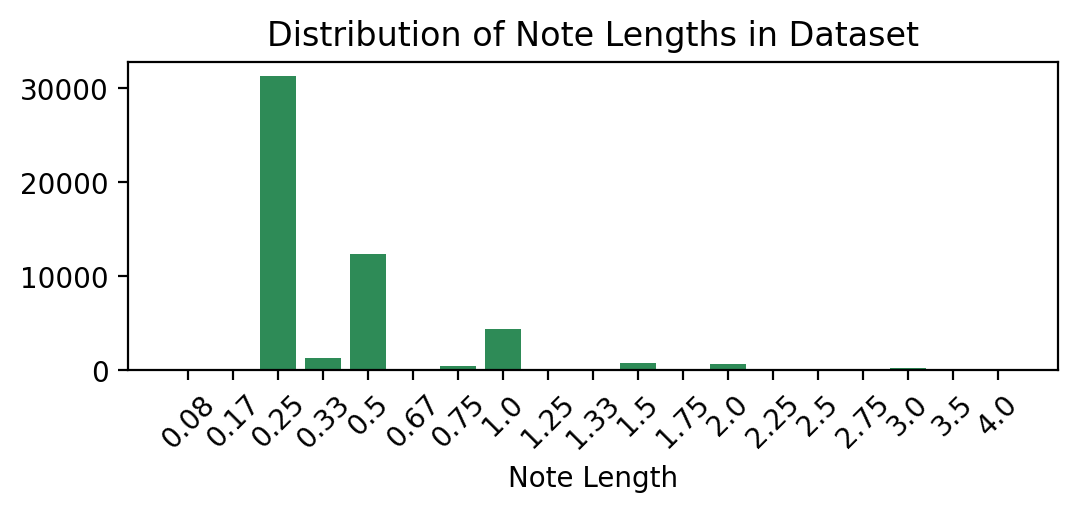

In [47]:
# Preprocess training data
train_data, note_to_int_mapping, duration_to_int_mapping = create_training_data_durations(clipped_notes, clipped_durations, seq_length=30)
X_train, X_test, y_train, y_test = train_test_split_and_reshape(train_data, verbose=True)

# Plot of Note Lengths Distribution
count = Counter(clipped_durations).most_common()
count = sorted(count, key=lambda x: x[0])  # Sort by duration
durs, counts = [str(round(val[0], 2)) for val in count], [val[1] for val in count]
plt.figure(figsize=(6, 2), dpi=100)
plt.bar(durs, counts, color="seagreen")
plt.title("Distribution of Note Lengths in Dataset")
plt.xlabel("Note Length")
plt.xticks(rotation=45)
plt.show()

<font color="blue"><b>Comment:</b></font> Looking at the note length distribution, we can see that a quarter length (0.25) is by far the most common note duration followed by 0.5 and 1.0. Because of the huge imbalance of the note durations, we assumed before training that the model would probably just learn to output a value of 0.25. <br><br>
Below we can see the model training for length prediciton. We can see that the model was stuck at an accuracy of 60% for the first 50 epochs. Just as we exprected the model defaulted to outputting the most frequent note. However the model was able to overcome this local optima and increased its validation accuracy up to 89%. This was more than we expected. 

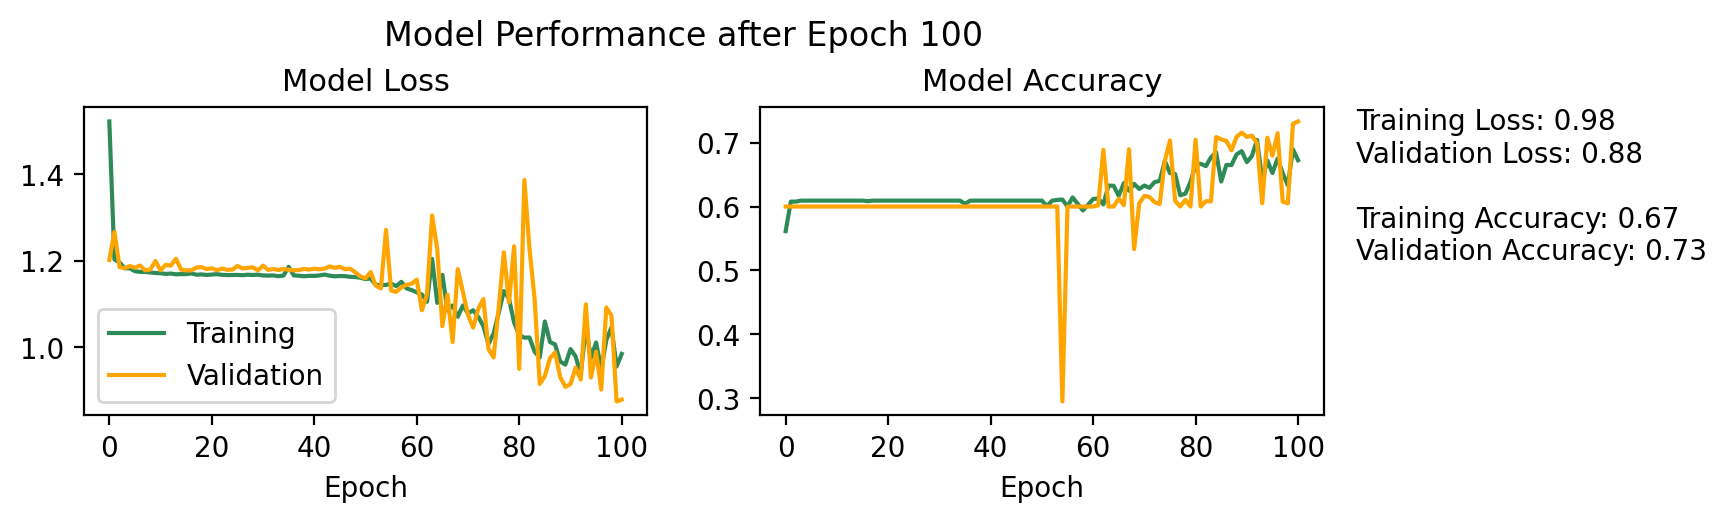

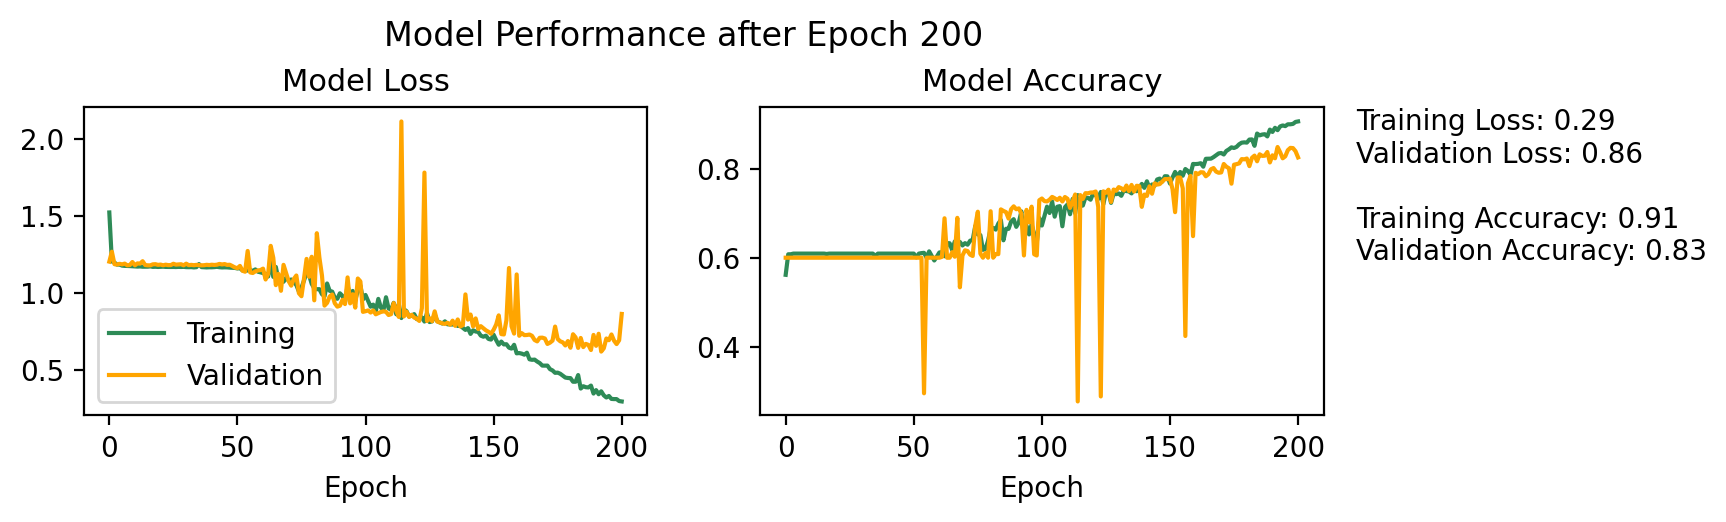

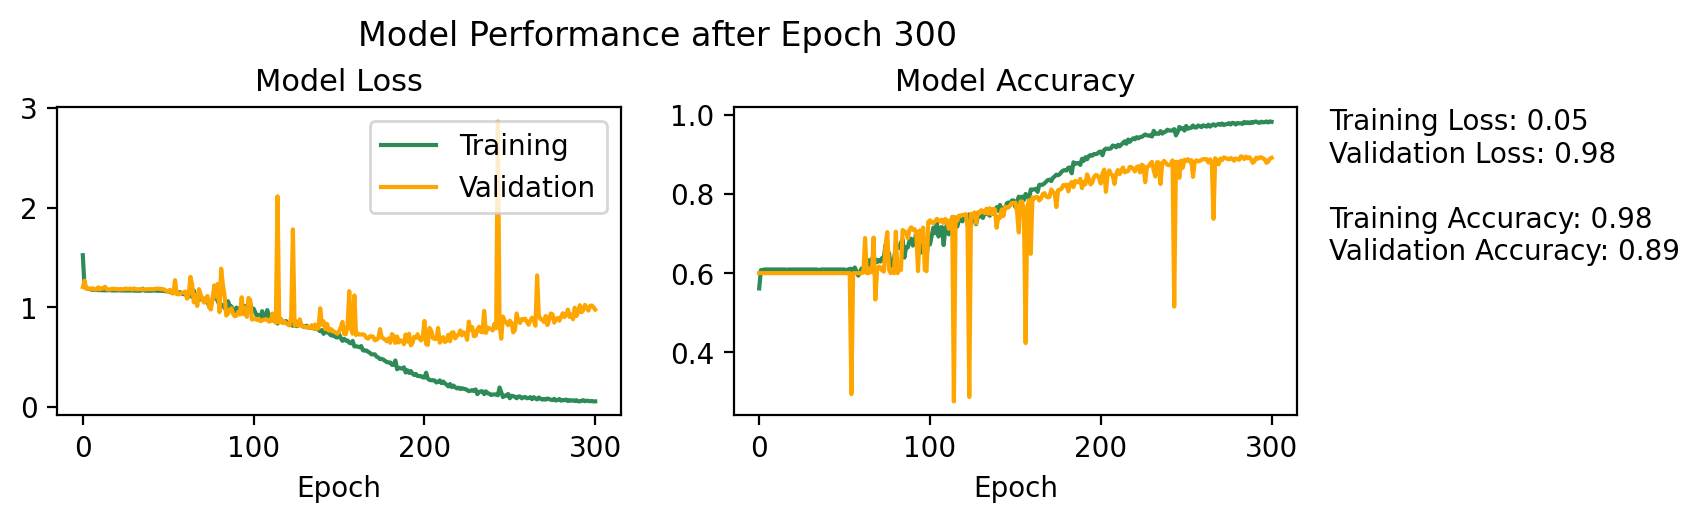

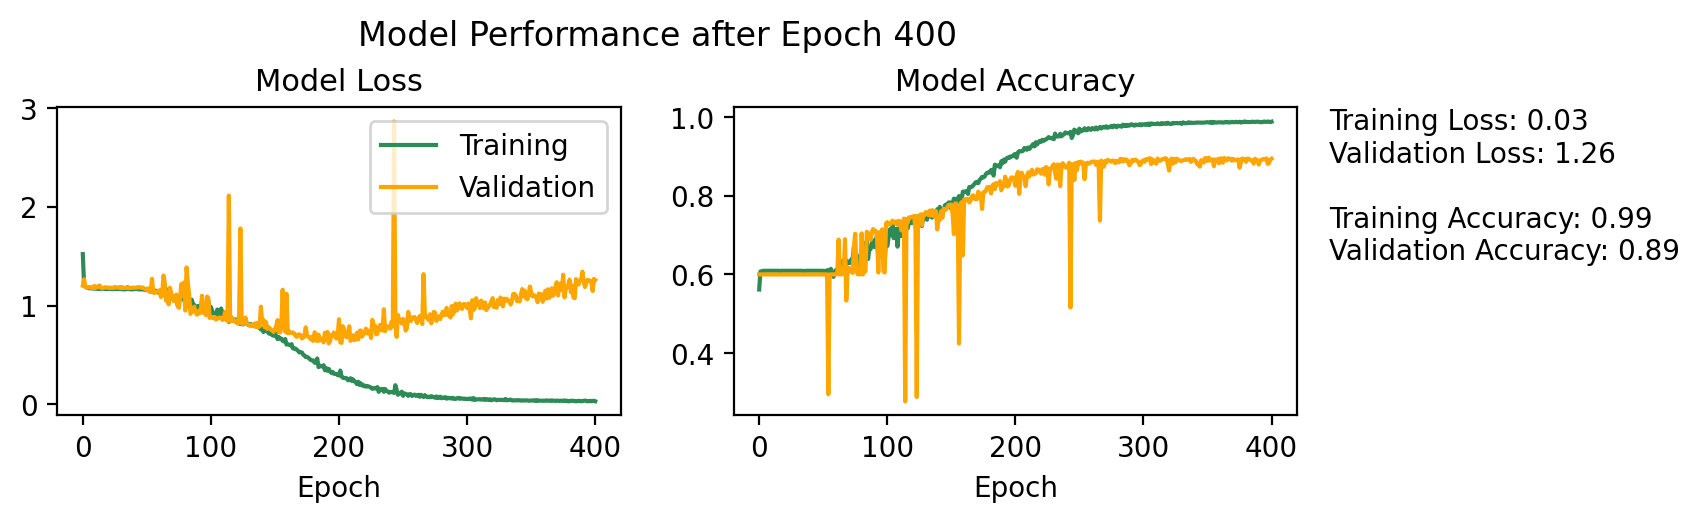

In [48]:
note_length_model = create_lstm_rnn(len(train_data["input"][0]), output_size=len(train_data["label"][0]), 
                                    num_lstm_layers=3, lstm_units=512)

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
note_length_model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=['accuracy'])
note_length_model.fit(X_train, y_train, batch_size=1024, epochs=401, verbose=0, validation_data=(X_test, y_test), 
                      callbacks=[PerfPlotCallback(100)])
    

<font color="blue"><h5>FUNCTION: Generate note lengths</h5></font>
This function takes a model for note length prediction and generates a sequence of note lengths according to the given note sequence and the starting note durations
* `model` = a model to predict a note duration based on the note, and the notes and note durations before.
* `entire_notes_seq` = Sequence of notes for which the note lengths are generated
* `starting_duration_seq` = The starting lengths of the note sequence. Must be at least as long as the input for the note durations at the provided model
* `note_to_int_mapping` = Note mapping used at the model training
* `duration_to_int_mapping` = Furation mapping used at the model training

In [44]:
def generate_note_lengths(model, entire_notes_seq, starting_duration_seq, note_to_int_mapping, duration_to_int_mapping):
    int_to_duration_mapping = {y: x for x, y in duration_to_int_mapping.items()}  # Flip mapping for easier use

    model_durr_seq_length = int(model.layers[0].input_shape[1]/2) # Get number of classes by looking at model input
    model_note_seq_length = model_durr_seq_length+1  # model has always one more note, as only duration is predicted
    
    predicted_lengths = starting_duration_seq[:model_durr_seq_length]  # Saved predicted lengths for entire_notes_seq. We keep the initial durations to make it easier later to match with the input data
    
    num_note_classes = len(note_to_int_mapping)
    num_durr_classes = len(duration_to_int_mapping)
    starting_duration_seq = starting_duration_seq[:model_durr_seq_length]

    moving_notes_seq = [note_to_int_mapping[note]/num_note_classes for note in entire_notes_seq[:model_note_seq_length]]
    moving_durrs_seq = [duration_to_int_mapping[dur]/num_durr_classes for dur in starting_duration_seq]


    for i in range(len(entire_notes_seq)-model_durr_seq_length):
        # Combine input sequences and convert shape for model input
        moving_complete_seq = moving_notes_seq + moving_durrs_seq
        moving_complete_seq = np.array(moving_complete_seq).reshape(1, model_durr_seq_length + model_note_seq_length, 1)  # Reshape

        # Predict duration of last note
        prediction = note_length_model.predict(moving_complete_seq)[0].tolist()
        pred_duration = int_to_duration_mapping[prediction.index(max(prediction))]
        predicted_lengths.append(pred_duration)

        # Append normalised predicition to duration list
        moving_durrs_seq = moving_durrs_seq[1:]
        moving_durrs_seq.append(duration_to_int_mapping[pred_duration]/num_durr_classes)

        # Move one forward with notes list
        moving_notes_seq = [note_to_int_mapping[note]/num_note_classes for note in entire_notes_seq[i:model_note_seq_length+i]]

    return predicted_lengths

<font color="blue"><b>Comment:</b></font> We first tested the duration prediction model with original mozart music to analyze the model performance. We can see the model mostly chooses a length of 0.25, which is expected as this is by far the most frequent duration in the training set. The model still varies the length of the notes. 

In [75]:
pred_lengths = generate_note_lengths(note_length_model, clipped_notes[1000:1200], clipped_durations, note_to_int_mapping, duration_to_int_mapping)
print(pred_lengths[13:])  # First 14 are initial input

[0.25, 0.25, 1.0, 0.25, 0.25, 0.25, 0.3333333333333333, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.5, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.5, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.3333333333333333, 0.5, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.6666666666666666, 0.75, 0.25, 0.25, 0.6666666666666666, 1.5, 1.5, 0.25, 0.25, 0.6666666666666666, 0.6666666666666666, 0.25, 0.25, 0.6666666666666666, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 1.5, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 1.5, 0.25, 0.25, 0.2

In [205]:
# Create midi
track_with_pred_lengths = create_midi(clipped_notes[1013:1200], pred_lengths[13:])
track_with_pred_lengths.show("midi")

# Save as file
track_with_pred_lengths.write("midi", f"./generated_music/track_w_dur_{datetime.now().strftime('%d_%m_%Y_%H_%M')}.mid")

'./generated_music/track_w_dur_05_05_2023_20_47.mid'

<font color="blue"><b>Comment:</b></font> After testing the duration model with original notes, we wanted to combine it with the note generation models created prior. We chose the GRU model we trained, as we believed the tracks it generated were the best sounding. Unfortunately due to time constraints, we could not convert this part to a more flexible function that would accept all types of note generation models. <br>
The below code first creates a sequence of notes from a random input sample of the mozart dataset with the GRU model and then feeds this output as well as the note durations of the input sample to our note length model. The result is a completely generated music track with notes and note lengths.<br>
The tracks can be found at **generated_music/mozart_note_and_length/*.mid**

In [81]:
# Preprocess notes and durations
all_files_notes, all_files_durations = extract_notes_from_midi_files("midi_files/mozart", flatten_list=True)
clipped_notes, clipped_durations = limit_different_notes(all_files_notes, all_files_durations, limit=100)

# Convert the notes to normalised ints for model input
seq_length = 20
i = random.randint(0, len(all_files_notes)-seq_length)
int_seq = [gru_model_note_to_int_mapping[val] for val in all_files_notes[i:i+seq_length]]
norm_seq = [val/len(note_to_int_mapping) for val in int_seq]
dur_seq = all_files_durations[i:i+seq_length]

# FIRST generate new music notes with the GRU model
start_sequence, generated_sequence = generate_new_music(gru_model, np.array(norm_seq), gru_model_note_to_int_mapping, length=200)
# SECOND generate durations to the generated notes with the note length model
pred_lengths = generate_note_lengths(note_length_model, start_sequence + generated_sequence, dur_seq, note_to_int_mapping, duration_to_int_mapping)

print("Input Sequence:\n", start_sequence)
print("Generated Sequence:\n", generated_sequence)
print("Generated Note Durations:\n", pred_lengths)

# Combine the outputs and save as file
gen_note_and_lengths = create_midi(start_sequence + generated_sequence, pred_lengths)
gen_note_and_lengths.write("midi", f"./generated_music/mozart_note_and_length_{datetime.now().strftime('%d_%m_%Y_%H_%M')}.mid")

Loaded notes from 21 midi files
Total number of notes: 55802
Number of unique notes: 638
Removed 4300 notes to get to 100 classes (51502 total notes remaining)
Input Sequence:
 ['C#6', 'B-_D', 'C#6', 'G2', 'C#6', 'G#4', 'C#6', 'G2', 'C#6', 'G#4', 'C#6', 'G_D', 'G#4', 'G_D', 'C#6', 'C#3', 'C#6', 'B_G', 'C#3', 'B_G']
Generated Sequence:
 ['D4', 'A3', 'E4', 'C5', 'C4', 'B4', 'C5', 'C5', 'E5', 'C5', 'B-4', 'F5', 'B-4', 'C5', 'E5', 'C5', 'F4', 'C5', 'C_D', 'C5', 'F4', 'F4', 'C5', 'B-4', 'E-5', 'D5', 'D5', 'C5', 'C5', 'C5', 'E-5', 'D5', 'E4', 'E-5', 'E-5', 'D5', 'D4', 'C4', 'C5', 'E-4', 'F4', 'C5', 'E-5', 'G4', 'G4', 'A3', 'E4', 'C_D', 'C5', 'C_D', 'E4', 'E4', 'D5', 'G#3', 'D5', 'C5', 'C_D', 'C5', 'C_D', 'C5', 'F4', 'C5', 'C_D', 'C5', 'C_D', 'C5', 'C_D', 'A3', 'E-5', 'F4', 'F#4', 'G4', 'A4', 'G4', 'G4', 'E6', 'E4', 'E-5', 'B5', 'D6', 'A3', 'A3', 'C_D', 'D6', 'E6', 'D6', 'E4', 'F5', 'C5', 'A3', 'C5', 'A2', 'A3', 'E4', 'C_D', 'E4', 'E6', 'F5', 'E-5', 'F_A', 'E6', 'C5', 'C_D', 'C5', 'C5', 'E4',

'./generated_music/mozart_note_and_length_09_05_2023_16_21.mid'

<font color="blue"><h5>Analysis</h5></font> 
The combined model produced surprisingly varied music with a diverse set of notes and a combination of slower and faster parts. In the end the results showed us that spliting the note and note-length prediction in 2 separate models is a valid approach to generating music with varied lengths. <br><br>
One potential problem/possible improvement we see with our model is that the notes and note lengths are fed into the same LSTM layer. Splitting the durations and notes into two separate input layers could improve performance as the time series would not be mixed with two different types of data.<br>
Another aspect our model does not consider is that the note could also be influenced by the duration of the previous notes. Because we chose the previously trained GRU model, only previous notes and not note lengths were considered for the note generation.

<font color="blue"><h4>Experiment with other data</h4></font>
Next we wanted to test how the models would perform with different training data. for this we downloaded kids songs from https://www.kinder-lieder.com and fed them into our models. With this test we also wanted to verify if the GRU model is in general better at music generation than the LSTM model, or if it depends on the training dataset. 

**1. GRU Model training** <br><br>
<font color="blue"><b>Note:</b></font> We can see in the plot below that the note distribution in the kids songs is not as diverse as in the classical music used before. There are also very few chords present

>> Creating training data
Loaded notes from 102 midi files
Total number of notes: 4805
Number of unique notes: 36
Removed 0 notes to get to 36 classes (4805 total notes remaining)
X_train: (3815, 35, 1) | y_train: (3815, 36) | X_test: (954, 35, 1) | y_test: (954, 36)


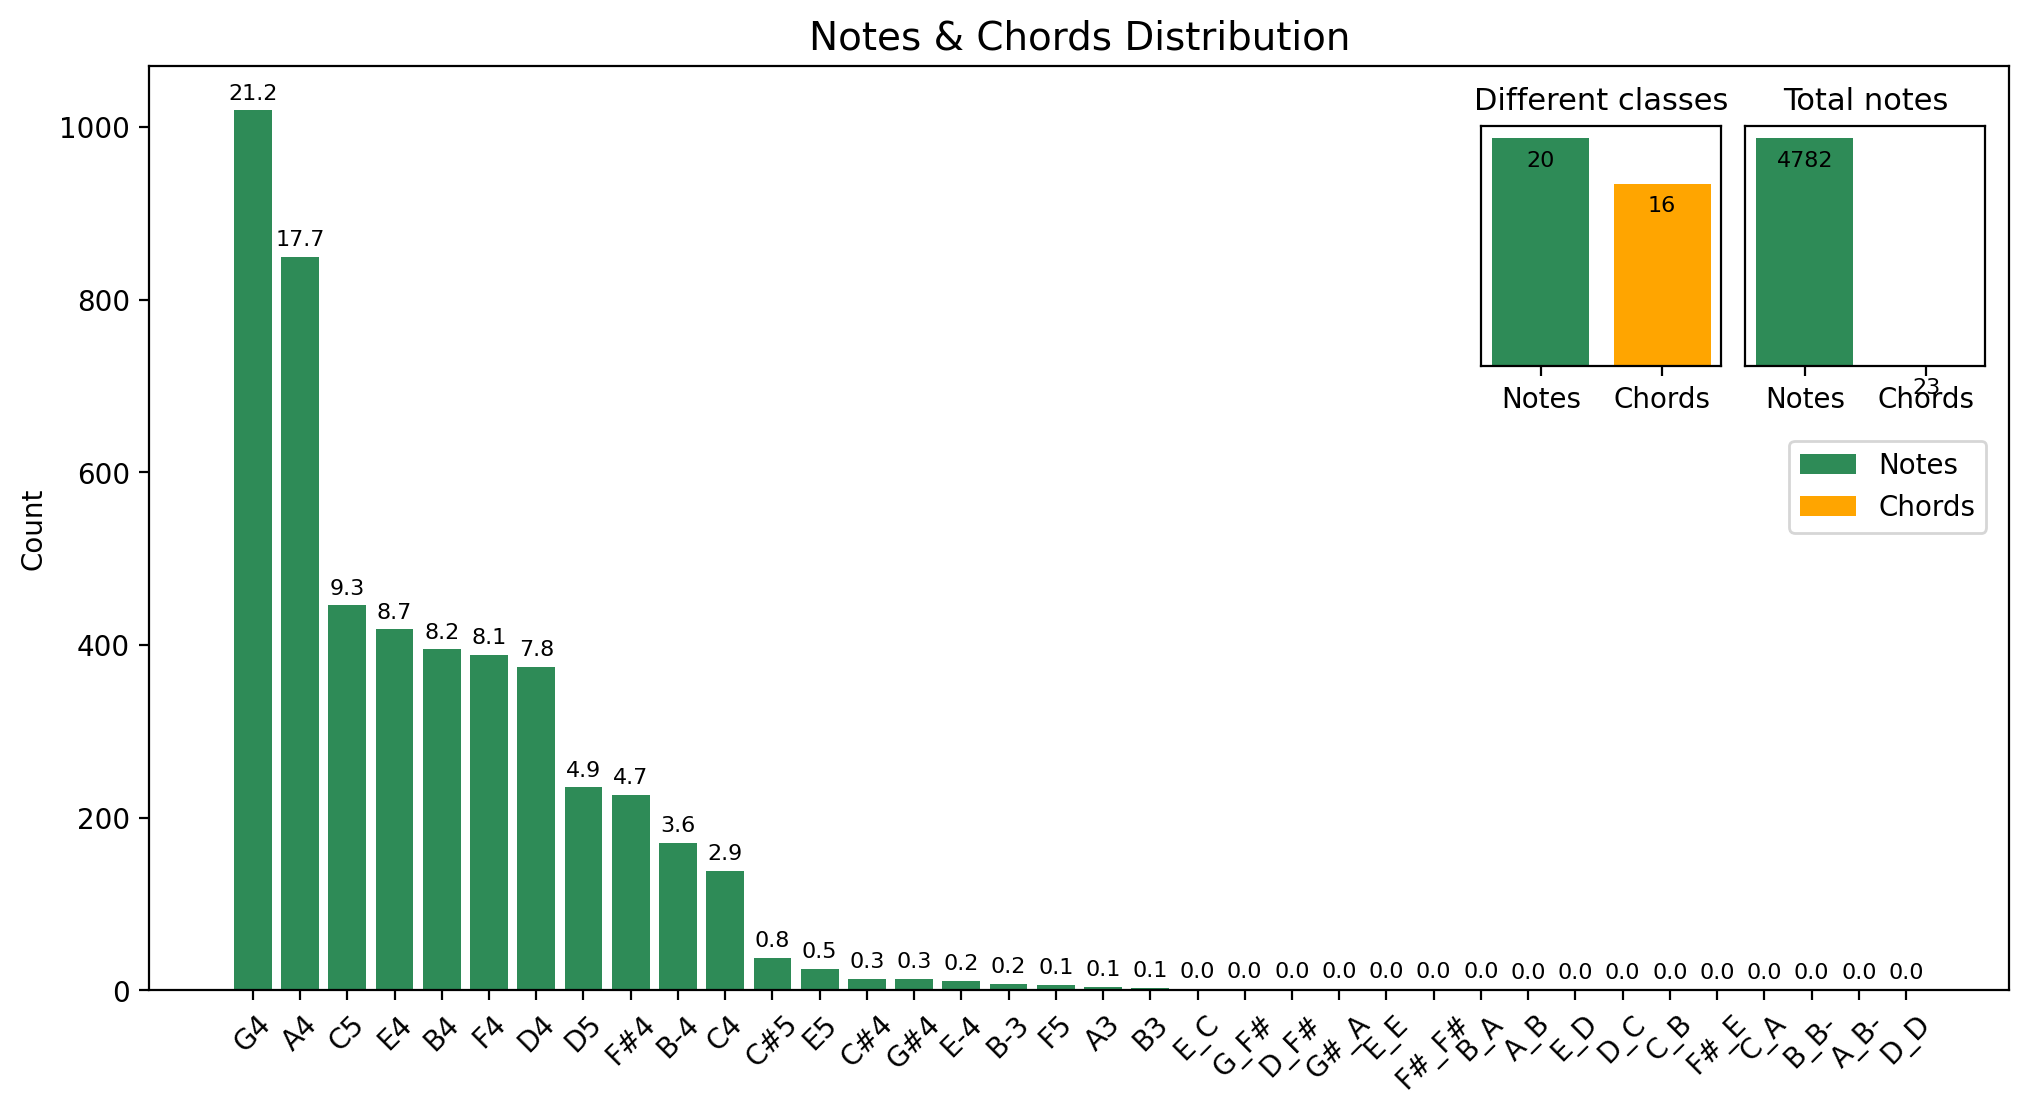


>> Building model

>> Beginning training


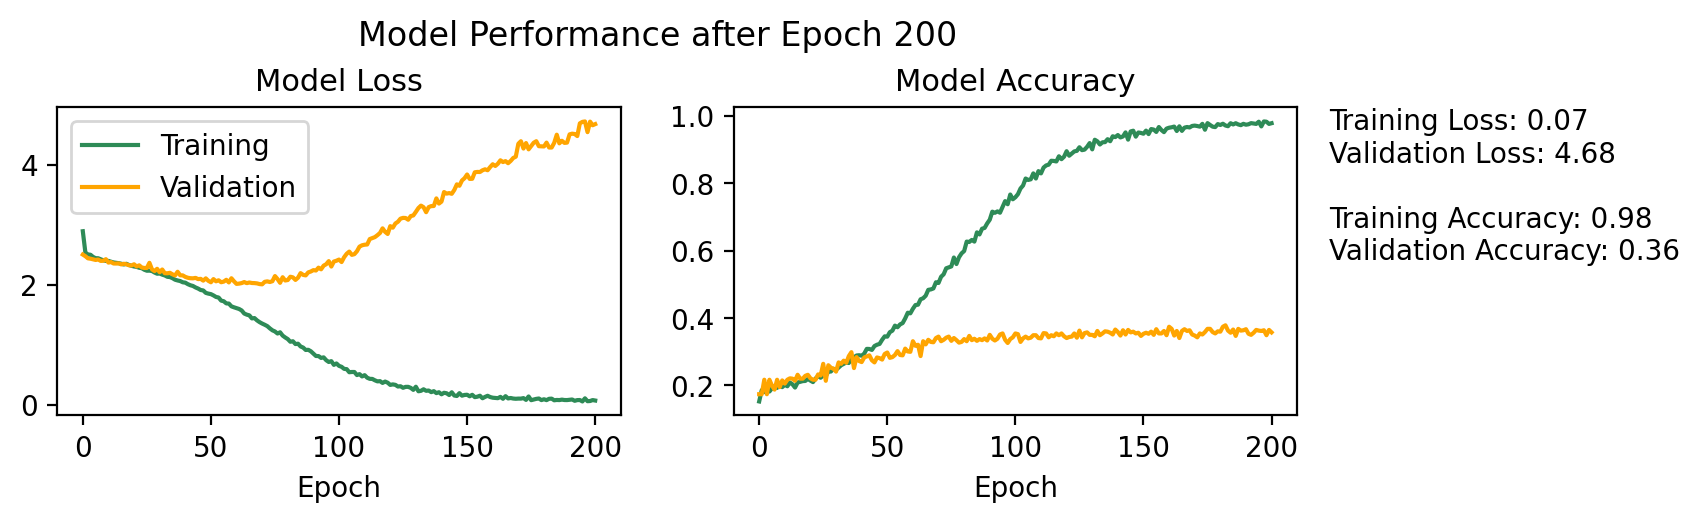


>> Finished training
Total training time: 3 minutes
Final training Loss: 0.06688080728054047
Final validation Loss: 4.675394535064697
Final training Accuracy: 0.9779816269874573
Final validation Accuracy: 0.35744234919548035


In [101]:
kids_song_gru_training_output = complete_gru_training("midi_files/kids_songs", max_classes=100, input_length=35, batch_size=256, plot_every_x_epochs=200, 
                                                       epochs=201, learning_rate=0.0005)

In [108]:
if not load_only_functions:
    input_sequence = random.choice(kids_song_gru_training_output["train_data"])  # Use a random training sequence as input
    start_sequence, generated_sequence = generate_new_music(kids_song_gru_training_output["model"], input_sequence, kids_song_gru_training_output["mappings"], length=500)

    print("Input Sequence:\n", start_sequence)
    print("Generated Sequence:\n", generated_sequence)

    # Save as file
    generated_stream = create_midi(generated_sequence)
    generated_stream.write("midi", f"./generated_music/kids_song_gru_{datetime.now().strftime('%d_%m_%Y_%H_%M')}.mid")

Input Sequence:
 ['C_B', 'E-4', 'G_F#', 'G_F#', 'E-4', 'E-4', 'E-4', 'D_D', 'G_F#', 'C_B', 'G_F#', 'D_D', 'D_D', 'D_D', 'D_D', 'B3', 'D_D', 'D_D', 'D5', 'D5', 'D5', 'D5', 'G_F#', 'G_F#', 'G_F#', 'D_D', 'D5', 'G_F#', 'G_F#', 'E-4', 'E-4', 'E-4', 'D_D', 'G_F#', 'G_F#']
Generated Sequence:
 ['G4', 'F4', 'D4', 'F4', 'F4', 'G4', 'G4', 'G4', 'G4', 'A4', 'E4', 'D4', 'E4', 'F4', 'F4', 'G4', 'G4', 'A4', 'G4', 'G4', 'E4', 'A_B', 'G4', 'A4', 'E4', 'G4', 'A4', 'G4', 'A4', 'G4', 'F4', 'G4', 'E4', 'C4', 'C4', 'C5', 'D5', 'B4', 'B-4', 'B4', 'G4', 'F4', 'G4', 'F4', 'D4', 'F4', 'B4', 'B4', 'B4', 'C5', 'C5', 'A4', 'B-4', 'G4', 'G4', 'G4', 'A4', 'A4', 'C5', 'A4', 'C5', 'C5', 'A4', 'C5', 'A4', 'B4', 'G4', 'G4', 'G4', 'G4', 'F#4', 'A4', 'F#4', 'F#4', 'F#4', 'A4', 'B4', 'G4', 'B4', 'B4', 'B4', 'F#4', 'G4', 'G4', 'D4', 'D4', 'A4', 'F#4', 'F#4', 'F#4', 'G4', 'E4', 'E4', 'F#4', 'F#4', 'G4', 'G4', 'A4', 'D4', 'D4', 'D4', 'G4', 'D5', 'D5', 'F4', 'F4', 'F4', 'G4', 'C4', 'C4', 'D4', 'D4', 'A4', 'C4', 'C4', 'F4', '

**2. LSTM Model training**

>> Creating training data
Loaded notes from 102 midi files
Total number of notes: 4805
Number of unique notes: 36
Removed 0 notes to get to 36 classes (4805 total notes remaining)
X_train: (3815, 35, 1) | y_train: (3815, 36) | X_test: (954, 35, 1) | y_test: (954, 36)

>> Building model

>> Beginning training


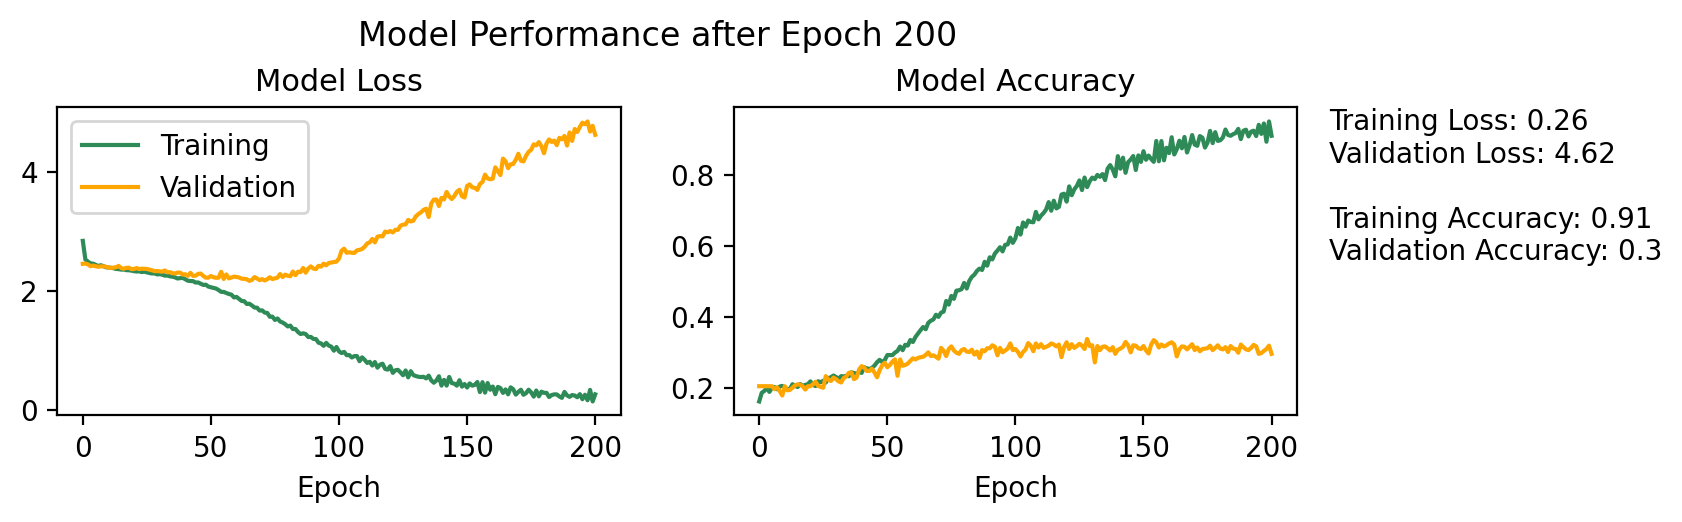


>> Finished training
Total training time: 4 minutes
Final training Loss: 0.2564391791820526
Final validation Loss: 4.6237945556640625
Final training Accuracy: 0.910091757774353
Final validation Accuracy: 0.29559749364852905


In [102]:
kids_song_lstm_training_output = complete_lstm_training("midi_files/kids_songs", max_classes=100, input_length=35, batch_size=256, plot_every_x_epochs=200, 
                                                       epochs=201, learning_rate=0.0005, plot_note_dist=False)

In [109]:
if not load_only_functions:
    input_sequence = random.choice(kids_song_lstm_training_output["train_data"])  # Use a random training sequence as input
    start_sequence, generated_sequence = generate_new_music(kids_song_lstm_training_output["model"], input_sequence, kids_song_lstm_training_output["mappings"], length=500)
    
    print("Input Sequence:\n", start_sequence)
    print("Generated Sequence:\n", generated_sequence)

    # Save as file
    generated_stream = create_midi(generated_sequence)
    generated_stream.write("midi", f"./generated_music/kids_song_lstm_{datetime.now().strftime('%d_%m_%Y_%H_%M')}.mid")

Input Sequence:
 ['A4', 'A4', 'A4', 'B3', 'G_F#', 'G_F#', 'G_F#', 'E-4', 'C5', 'E-4', 'C5', 'E_D', 'C5', 'B3', 'G_F#', 'G_F#', 'G_F#', 'E-4', 'C5', 'E-4', 'C5', 'E_D', 'D_C', 'F4', 'F4', 'E_D', 'E_D', 'F4', 'F4', 'D_C', 'G_F#', 'G_F#', 'F4', 'E_D', 'F4']
Generated Sequence:
 ['A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'G4', 'G4', 'F#4', 'G4', 'F#4', 'D4', 'D4', 'D4', 'B4', 'B4', 'B4', 'B4', 'B4', 'C5', 'C5', 'F4', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'D5', 'C5', 'E5', 'C5', 'C5', 'C5', 'C5', 'F4', 'F4', 'F4', 'E4', 'E4', 'E4', 'A4', 'D4', 'E4', 'C4', 'C4', 'C4', 'G4', 'G4', 'C4', 'F4', 'F4', 'F4', 'F4', 'G4', 'G4', 'G4', 'A4', 'C4', 'C4', 'A4', 'A4', 'E4', 'A4', 'G4', 'G4', 'A4', 'A4', 'A4', 'A4', 'F4', 'F4', 'F4', 'F4', 'G4', 'G4', 'G4', 'B-4', 'C5', 'C5', 'C5', 'F4', 'C4', 'C4', 'F4', 'B-4', 'B-4', 'G4', 'G4', 'C5', 'A4', 'F4', 'G4', 'F4', 'F4', 'C5', 'C5', 'C#4', 'C5', 'C5', 'F#4', 'A4', 'C5', 'F4', 'F4', 'F4', 'E4', 'E4', 'A4', 'G4', 'G4', 'E4', 'C5', 'E4', 'E4', 'A4', 'A4', 'A4', 'D4', 'D

<font color="blue"><b>Comment:</b></font> The generated midi files can be found at the following locations: <br>
* GRU Model = **generated_music/kids_song_gru/*.mid**
* LSTM Model = **generated_music/kids_song_lstm/*.mid**

<font color="blue"><h5>Analysis</h5></font> 
Both models are able to generate diverse note sequences when trained on kids songs. A collapse to a single note later in the track does not happen in any of the two models. However in one case the LSTM model was stuck at one note sequence repeating it until the end (See kids_song_lstm_09_05_2023_19_33.mid). In general, we believe that the songs generated by GRU sounded better and a little bit more natural. The LSTM model was often repeating the same note several times before switching to a new one. A problem, that did not occur as much with the GRU model. <br><br>
We conclude from this limited test that the GRU model is likely the better choice for generating music. It outperformed the LSTM model in both classical music and kids songs and was more robust to collapsing in the later parts of the tracks.

<font color="blue"><h4>Aspects we could not test</h4></font>
As training takes a long time, we could not test all aspects we planned at the beginning when setting up our training functions. These were:
* Testing the implementation of pauses. We integrated this feature into our note extraction functions but due to the low priority could not test it. We suspect, that the implementation of pauses would have succeeded as they are similar to just another note class as input.
* Testing different layer and unit counts for the lstm and GRU models. We implemented the keras model creation functions in a way that the number of layers and units of the recurrent layers could easily be configured. We could not test this aspect in part because of time constraints and in part because of the sufficient enough performance of the base models

<font color="blue"><h3>Conclusion</h3></font>
Generating music by providing only a few midi files is pretty impressive. The concept of taking the midi terms of „on“ and „off“, converting them into strings and building up a format that can be used as input for RNNs shows the versatility of neural networks. As we got some freedom in what we wanted to test further, the task demanded some creativity. This on one hand was appreciated, and on the other hand hindered the prevention of errors such as a too high learning rate directly in the beginning. It also showed us, that the success with generating music is rather subjective.

Music21 provides some starting points on visualising and experimenting with Music and Neural Networks.
Although the library itself is quite powerful, different alternations and additional imports were mandatory to actually use it in the local environment. Also, for instance, the 
`.show` command didn’t work in the Jupyter Lab Environment on the Cluster. Although this took some time in the beginning, the understanding of notes and array structure helped a lot while training.

The only thing limiting the generating music „experience“ was the time of learning. More data would be better for the model, but even the GPU took a lot of time learning. This prevented us from experimenting with more parameters and architectures. The time was indicated with the output of the `complete_lstm_training` function.

Integrating new features such as note duration and different RNN architectures (GRU instead of LSTM) showed the variety of alterations that can be tested. A GRU model in our experience would be the way to go when choosing an RNN architecture for music generation.

### Bonus

<font color="blue"><h5>FAILED EXPERIMENT: Generating notes based on semitone difference</h5></font>
We also had the idea of predicting notes based on the semitone difference. Our idea was that we wouldnt need to remove notes to limit the scope because only the difference between the notes would be predicted. We also switched from a one-hot-encoding to a regression output as it would be more fitting for a semitone difference. <br><br>
However, our attempts were not successfull. The model was not able to learn the desired semitone differences and produced always the same output. We tried a couple of different hyperparameter combinations but none of them improved the result. <br><br>
We assume that the reason is some fault in our code because the model seems to not train at all, however, we could not find the root of the problem.

<font color="blue"><b>Comment:</b></font>  We converted chords to their base tone in order to be able to calculate a semitone difference

In [110]:
def convert_chords(notes_list, chord_separator="_"):
    only_notes = []
    for note in notes_list:
        if chord_separator in note:
            only_notes.append(music21.chord.Chord(note.split("_")).root().nameWithOctave)
        else:
            only_notes.append(note)
    return only_notes

In [111]:
def get_semitone_difference(notes_list):
    semitone_diff = []
    for i in range(len(notes_list)-1):
        n1 = music21.note.Note(notes_list[i])
        n2 = music21.note.Note(notes_list[i+1])
        semitone_diff.append(music21.interval.Interval(n1, n2).semitones)
    print(f"Extracted semitone difference for {len(notes_list)} notes (maximum increase: {max(semitone_diff)}, maximum decrease: {min(semitone_diff)}).")
    return semitone_diff

In [112]:
files_notes, files_durations = extract_notes_from_midi_files("./midi_files/mozart", normalize_chords=False)
notes_conv_chords = convert_chords(files_notes)
semitone_diff = get_semitone_difference(notes_conv_chords)

Loaded notes from 21 midi files
Total number of notes: 55802
Number of unique notes: 1355
Extracted semitone difference for 55802 notes (maximum increase: 49, maximum decrease: -43).


In [113]:
print(semitone_diff[:100])

[0, 0, 0, -1, 1, 5, -5, -3, 3, -8, 3, -2, 0, -1, 1, 5, 4, -2, -7, -6, 5, 1, -5, 7, 0, -2, -1, 3, 0, 12, -8, -4, 0, 0, 0, 0, 12, 4, 0, -2, -2, -2, -1, 8, -11, 1, 3, 4, -9, 4, -2, -2, 0, 0, 0, 0, -1, 1, 5, -5, -3, 3, -8, 3, -2, 0, -1, 1, 5, 4, -2, -7, -6, 5, 1, -5, 7, 0, -2, -1, 3, 0, 12, -8, -4, 0, 0, 0, 0, 12, 4, 0, -2, -2, -2, -1, 8, -11, 1, 3]


<font color="blue"><b>Comment:</b></font> We checked to see if the reason of the model failure was in the semitone differences, however these seem to be calculated correctly.

In [114]:
def create_training_data_diff(diff_list, seq_length=50, max_diff=50):
    data = {"input": [], "label": []}
    for i in range(len(diff_list))[:-(seq_length+1)]:
        norm_seq = [val/max_diff for val in diff_list[i:i+seq_length]]
        data["input"].append(norm_seq)
        data["label"].append([diff_list[i+seq_length]/max_diff])
    
    return data

In [115]:
train_data = create_training_data_diff(semitone_diff, seq_length=30)
print(train_data["input"][0])
print(train_data["label"][0])

X_train, X_test, y_train, y_test = train_test_split_and_reshape(train_data, verbose=True)

[0.0, 0.0, 0.0, -0.02, 0.02, 0.1, -0.1, -0.06, 0.06, -0.16, 0.06, -0.04, 0.0, -0.02, 0.02, 0.1, 0.08, -0.04, -0.14, -0.12, 0.1, 0.02, -0.1, 0.14, 0.0, -0.04, -0.02, 0.06, 0.0, 0.24]
[-0.16]
X_train: (44616, 30, 1) | y_train: (44616, 1) | X_test: (11154, 30, 1) | y_test: (11154, 1)


<font color="blue"><b>Comment:</b></font> The create_lstm_rnn function was adapted for regression to include one output value with a linear activation function

In [116]:
def create_lstm_rnn_cont(input_length, num_lstm_layers=3, lstm_units=512):
    model = tf.keras.Sequential()

    # Add LSTM layers (LSTMs need input shape (batch_size, timesteps, features))
    for i in range(num_lstm_layers):
        model.add(tf.keras.layers.LSTM(input_shape=(input_length,1,), units=lstm_units, return_sequences=True if i < num_lstm_layers-1 else False))
        model.add(tf.keras.layers.Dropout(.3))
        
    # Add dense layers
    model.add(tf.keras.layers.Dense(units=256, activation="ReLU"))
    model.add(tf.keras.layers.Dropout(.3))
    model.add(tf.keras.layers.Dense(units=1, activation="linear"))

    return model

<font color="blue"><b>Comment:</b></font>  A separate performance callback was created to plot performance metrics during training:

In [117]:
class PerfPlotCallbackRegression(tf.keras.callbacks.Callback):
    def __init__(self, plot_every_x_epochs=10):
        super().__init__()
        self.train_loss = []
        self.test_loss = []
        self.train_mae = []
        self.test_mae = []
        self.plot_every_x_epochs = plot_every_x_epochs
        
    @tf.function
    def on_epoch_end(self, epoch, logs=None):
        self.train_loss.append(logs["loss"])
        self.test_loss.append(logs["val_loss"])
        self.train_mae.append(logs["mae"])
        self.test_mae.append(logs["val_mae"])
        
        if epoch % self.plot_every_x_epochs == 0 and epoch != 0:
            fig = plt.figure(figsize=(8, 2), dpi=100)
            fig.suptitle(f"Model Performance after Epoch {epoch}", y=1.1)
            plt.figtext(.92, .5, f"Training Loss: {round(logs['loss'], 2)}\nValidation Loss: {round(logs['val_loss'], 2)}\n\nTraining MAE: {round(logs['mae'], 2)}\nValidation MAE: {round(logs['val_mae'], 2)}")
            
            plt.subplot(1, 2, 1)
            plt.title("Model Loss", fontsize=11)
            plt.plot(self.train_loss, color="seagreen", label="Training")
            plt.plot(self.test_loss, color="orange", label="Validation")
            plt.legend()
            plt.xlabel("Epoch")
            
            plt.subplot(1, 2, 2)
            plt.title("Model MAE", fontsize=11)
            plt.plot(self.train_mae, color="seagreen", label="Training")
            plt.plot(self.test_mae, color="orange", label="Validation")
            plt.xlabel("Epoch")
            
            plt.show()

<font color="blue"><b>Comment:</b></font> Because we switched to a regression output, we used Mean squared error for calculating the loss and displayed the MAE as performance metric.

In [130]:
diff_model = create_lstm_rnn_cont(input_length=len(train_data["input"][0]))
diff_model.summary()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
diff_model.compile(optimizer=optimizer, loss="mse", metrics=['mae'])

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_30 (LSTM)               (None, 30, 512)           1052672   
_________________________________________________________________
dropout_88 (Dropout)         (None, 30, 512)           0         
_________________________________________________________________
lstm_31 (LSTM)               (None, 30, 512)           2099200   
_________________________________________________________________
dropout_89 (Dropout)         (None, 30, 512)           0         
_________________________________________________________________
lstm_32 (LSTM)               (None, 512)               2099200   
_________________________________________________________________
dropout_90 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_44 (Dense)             (None, 256)             

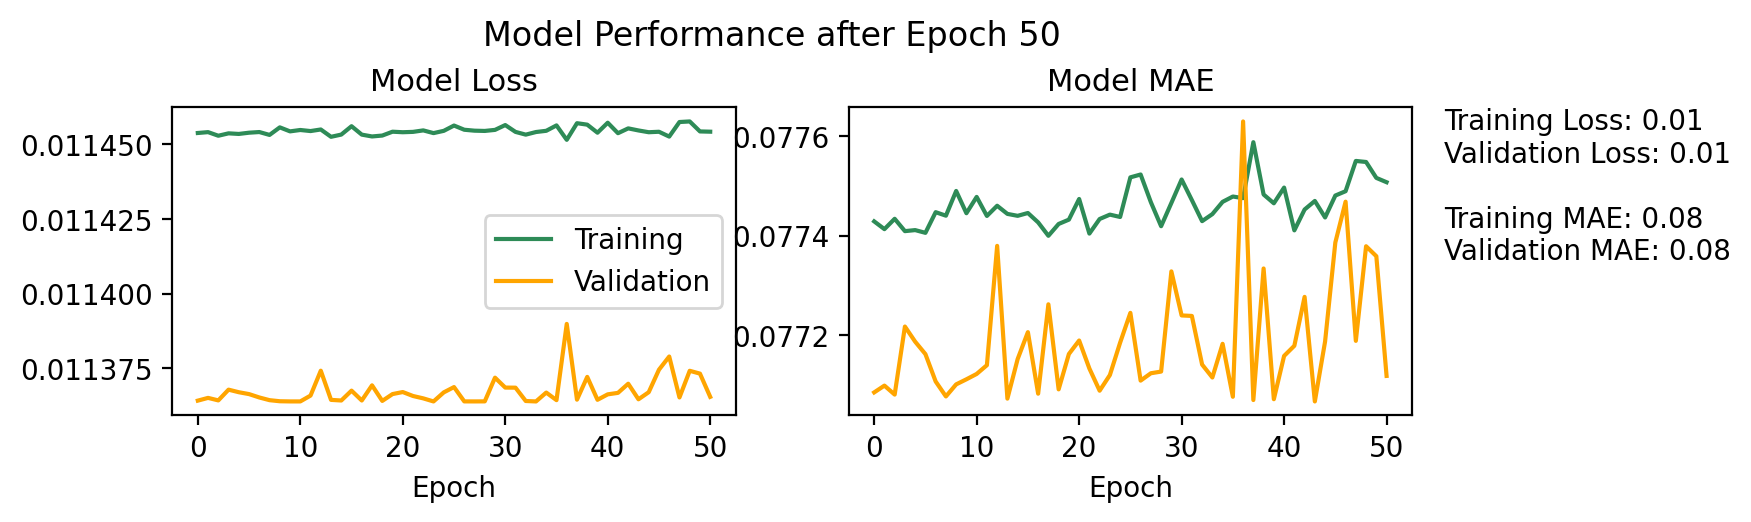

In [132]:
diff_model.fit(X_train, y_train, batch_size=1024, epochs=51, verbose=0, validation_data=(X_test, y_test), 
               callbacks=[PerfPlotCallbackRegression(50)])

<font color="blue"><b>Comment:</b></font> Despite the low MAE and Loss, the model always outputs the same value (See below).

In [123]:
def generate_new_diff_music(model, start_sequence, length, max_diff=50):
    generated_sequence = []  # List for storing generated notes
    num_classes = model.layers[0].input_shape[1]  # Get number of classes by looking at model input
    
    # Reshape input sequence if necessary
    if len(start_sequence.shape) != 3:
        start_sequence = start_sequence[:num_classes].reshape(1, num_classes, 1)
    moving_sequence = copy.deepcopy(start_sequence)

    # Model Inference = Create music
    for i in range(length):
        prediction = model.predict([moving_sequence])[0].tolist()
        print(prediction)
        pred_note_name = prediction * max_diff
        moving_sequence = np.delete(moving_sequence, 0, axis=1) # Remove first element
        moving_sequence = np.append(moving_sequence, np.array([[prediction]]).reshape(1, 1, 1), axis=1)
        generated_sequence.append(pred_note_name)
        
    return generated_sequence

In [133]:
input_sequence = random.choice(X_train)  # Use a random training sequence as input
a = generate_new_diff_music(diff_model, input_sequence, 10)

[0.00039835297502577305]
[0.00039835297502577305]
[0.00039835297502577305]
[0.00039835297502577305]
[0.00039835297502577305]
[0.00039835297502577305]
[0.00039835297502577305]
[0.00039835297502577305]
[0.00039835297502577305]
[0.00039835297502577305]


<font color="blue"><b>Comment:</b></font> In the end we could not get the model to work. We decided to keep this part in the notebook to showcase one of several dead-ends we met during this exercise.